<a href="https://colab.research.google.com/github/alexandrastna/AI-for-ESG/blob/main/Notebooks/11_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Environment Setup and Data Import

In [1]:
# 1. Setup (Colab + imports)

# I mount my Google Drive to access my files
from google.colab import drive
drive.mount('/content/drive')

# Libraries I will use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau, pearsonr

# Paths to my data
scores_path = "/content/drive/MyDrive/Thèse Master/Exports2/Score"   # my Thesis 9 score exports
refinitiv_path = "/content/drive/MyDrive/Thèse Master/Data/SMI companies.xlsx"  # Refinitiv Excel file
year = 2022   # year I want to analyze (latest year with no missing data)


Mounted at /content/drive


In [2]:
# 2. Load and prepare carbon data + my E scores (simple helpers + clean merge)

import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def parse_comma_float(x):
    # I convert numbers written with commas (e.g. "4309,13") to floats.
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float, np.number)):
        return float(x)
    s = str(x).strip().replace(" ", "")
    s = s.replace(".", "").replace(",", ".")  # remove thousands dot, then swap comma to dot
    try:
        return float(s)
    except:
        return np.nan

def rank_desc(s):
    # Rank where higher is better (rank 1 = highest value)
    return s.rank(ascending=False, method="min")

def rank_asc(s):
    # Rank where lower is better (rank 1 = lowest value)
    return s.rank(ascending=True, method="min")

def mean_abs_rank_error(r1, r2):
    # On average, how many rank positions apart are two rankings?
    m = r1.notna() & r2.notna()
    if m.sum() == 0:
        return np.nan
    return (r1[m] - r2[m]).abs().mean()

def jaccard_topk(a, b):
    # Jaccard overlap between two sets (0 = no overlap, 1 = perfect)
    return len(a & b) / len(a | b) if (len(a | b) > 0) else np.nan

### 2. Data Visualization and Quality Checks

In [3]:
# 2.1 Load carbon intensities for my target year
#    (I keep both Total scope 1–3 and “without scope 3”)
carb = pd.read_excel(refinitiv_path, sheet_name="Refinitiv Carbon Intensity")
carb = carb.rename(columns={
    "company": "Company",
    "year": "year",
    "Total emissions intensity (tonnes CO2e/$ Million)": "Carbon_Total",
    "Total emissions intensity without Scope 3": "Carbon_wo_Scope3",
})
carb["Company"] = carb["Company"].astype(str).str.strip()
carb["year"] = carb["year"].astype(int)
carb["Carbon_Total"] = carb["Carbon_Total"].apply(parse_comma_float)
carb["Carbon_wo_Scope3"] = carb["Carbon_wo_Scope3"].apply(parse_comma_float)

# I also keep log versions for later (only for value-based scatter/Pearson)
carb["Carbon_Total_log"] = np.log1p(carb["Carbon_Total"])
carb["Carbon_wo_Scope3_log"] = np.log1p(carb["Carbon_wo_Scope3"])

carb_year = carb.query("year == @year")[[
    "Company","Carbon_Total","Carbon_wo_Scope3","Carbon_Total_log","Carbon_wo_Scope3_log"
]].copy()

print(f"Carbon data ({year}) – shape:", carb_year.shape)
display(carb_year.head(10))


Carbon data (2022) – shape: (10, 5)


,Company,Carbon_Total,Carbon_wo_Scope3,Carbon_Total_log,Carbon_wo_Scope3_log
1,ABB Ltd,13299.746,7.490,9.495575,2.138889
4,Compagnie Financière Richemont,82.606,3.719,4.426115,1.551597
7,Holcim Ltd,4215.455,2646.914,8.346750,7.881527
10,Lonza Group AG,366.637,83.536,5.907096,4.437177
13,Nestlé SA,1158.483,59.112,7.055729,4.096209
16,Novartis AG,127.190,12.055,4.853514,2.569171
19,Roche Holding AG,101.991,5.483,4.634642,1.869183
22,Swiss Re Ltd,3.255,0.225,1.448095,0.202941
25,UBS Group AG,7.455,4.760,2.134758,1.750937
28,Zurich Insurance Group AG,115.790,0.427,4.760377,0.355574


In [4]:
# 2.2 Load my E pillar scores (df1_* -> E1, df2_* -> E2, ...)

import os, re
import pandas as pd
import numpy as np
from IPython.display import display

def detect_e_col(df):
    # I prefer a clean E_score. If not there, I fallback to E_net or E_pos_ratio.
    for c in ["E_score", "E_net", "E_pos_ratio"]:
        if c in df.columns:
            return c
    return None

# I only keep files that look like df1_*.csv, df2_*.csv, ..., df10_*.csv
indexed_files = []
for fname in os.listdir(scores_path):
    if fname.lower().endswith(".csv"):
        m = re.match(r"^df(\d+)_", fname)
        if m:
            num = int(m.group(1))
            if 1 <= num <= 10:  # I only keep the first 10 variants
                indexed_files.append((num, fname))

indexed_files = sorted(indexed_files, key=lambda x: x[0])

e_rows = []
manifest_rows = []  # I keep a small summary so I can check what fed each E

for v, fname in indexed_files:
    path = os.path.join(scores_path, fname)
    try:
        tmp = pd.read_csv(path)
    except Exception:
        continue

    # I need at least company/year
    if not {"company", "year"}.issubset(tmp.columns):
        continue

    ecol = detect_e_col(tmp)
    if ecol is None:
        # file is not an E pillar file (maybe an ESG-total file), I skip it
        continue

    # I keep only my target year, and one column = the chosen E metric
    sub = tmp.loc[tmp["year"] == year, ["company", "year", ecol]].copy()
    sub = sub.rename(columns={"company": "Company", ecol: "E_value"})
    sub["variant"] = v
    e_rows.append(sub)

    # I log what I used (file + column), so I know exactly what E{v} means
    manifest_rows.append({"E_variant": f"E{v}", "file": fname, "E_column_used": ecol})

if not e_rows:
    raise RuntimeError("I did not find any dfN_* CSV with an E column (E_score / E_net / E_pos_ratio).")

# I pivot to wide: Company × (E1..E10)
E_all = pd.concat(e_rows, ignore_index=True)
E_year = (
    E_all
      .pivot_table(index="Company", columns="variant", values="E_value", aggfunc="first")
      .reset_index()
)

# Rename numeric columns 1..10 -> E1..E10
E_year = E_year.rename(columns={c: f"E{int(c)}" for c in E_year.columns if isinstance(c, (int, np.integer))})

print(f"My E variants ({year}) – shape:", E_year.shape)
display(E_year.head())

# I also show the manifest so I can double-check which file/column feeds each E
e_manifest = pd.DataFrame(manifest_rows).sort_values("E_variant").reset_index(drop=True)
print("E variant manifest (this is exactly what E1..E10 mean):")
display(e_manifest)


My E variants (2022) – shape: (10, 11)


variant,Company,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10
0,ABB Ltd,0.184680,0.104695,0.043592,0.024713,0.128680,0.072949,0.727056,0.412168,0.767580,0.435141
1,Compagnie Financière Richemont,0.070517,0.007052,0.029026,0.002903,0.030118,0.003012,0.695980,0.069598,0.733668,0.073367
2,Holcim Ltd,0.188268,0.121357,0.098105,0.063238,0.176767,0.113944,0.755599,0.487059,0.793574,0.511537
3,Lonza Group AG,0.099283,0.009928,0.021518,0.002152,0.035244,0.003524,0.573427,0.057343,0.638695,0.063869
4,Nestlé SA,0.109457,0.049256,0.027019,0.012159,0.045722,0.020575,0.711260,0.320067,0.783724,0.352676


E variant manifest (this is exactly what E1..E10 mean):


,E_variant,file,E_column_used
0,E1,df1_ESG_quantity.csv,E_score
1,E10,df10_Pos_only_SASB.csv,E_pos_ratio
2,E2,df2_ESG_quantity_SASB.csv,E_score
3,E3,df3_ESG_earnings.csv,E_score
4,E4,df4_ESG_earnings_SASB.csv,E_score
5,E5,df5_ESG_no_comm.csv,E_score
6,E6,df6_ESG_no_comm_SASB.csv,E_score
7,E7,df7_Pos_minus_Neg.csv,E_net
8,E8,df8_Pos_minus_Neg_SASB.csv,E_net
9,E9,df9_Pos_only.csv,E_pos_ratio


In [5]:
# 2.3 Merge carbon + E scores, just to see everything together
df = carb_year.merge(E_year, on="Company", how="inner")
print("Merged (Carbon + E variants) – companies in common:", df["Company"].nunique())
display(df.head(10))


Merged (Carbon + E variants) – companies in common: 10


,Company,Carbon_Total,Carbon_wo_Scope3,Carbon_Total_log,Carbon_wo_Scope3_log,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10
0,ABB Ltd,13299.746,7.490,9.495575,2.138889,0.184680,0.104695,0.043592,0.024713,0.128680,0.072949,0.727056,0.412168,0.767580,0.435141
1,Compagnie Financière Richemont,82.606,3.719,4.426115,1.551597,0.070517,0.007052,0.029026,0.002903,0.030118,0.003012,0.695980,0.069598,0.733668,0.073367
2,Holcim Ltd,4215.455,2646.914,8.346750,7.881527,0.188268,0.121357,0.098105,0.063238,0.176767,0.113944,0.755599,0.487059,0.793574,0.511537
3,Lonza Group AG,366.637,83.536,5.907096,4.437177,0.099283,0.009928,0.021518,0.002152,0.035244,0.003524,0.573427,0.057343,0.638695,0.063869
4,Nestlé SA,1158.483,59.112,7.055729,4.096209,0.109457,0.049256,0.027019,0.012159,0.045722,0.020575,0.711260,0.320067,0.783724,0.352676
5,Novartis AG,127.190,12.055,4.853514,2.569171,0.022326,0.002233,0.011516,0.001152,0.014235,0.001423,0.209790,0.020979,0.321678,0.032168
6,Roche Holding AG,101.991,5.483,4.634642,1.869183,0.034596,0.003460,0.009893,0.000989,0.034596,0.003460,0.506329,0.050633,0.550633,0.055063
7,Swiss Re Ltd,3.255,0.225,1.448095,0.202941,0.172946,0.077826,0.023353,0.010509,0.128392,0.057777,0.491917,0.221363,0.590454,0.265704
8,UBS Group AG,7.455,4.760,2.134758,1.750937,0.148002,0.049300,0.011786,0.003926,0.038655,0.012876,0.568531,0.189378,0.627273,0.208945
9,Zurich Insurance Group AG,115.790,0.427,4.760377,0.355574,0.136946,0.061625,0.009679,0.004356,0.136946,0.061625,0.385870,0.173641,0.446739,0.201033


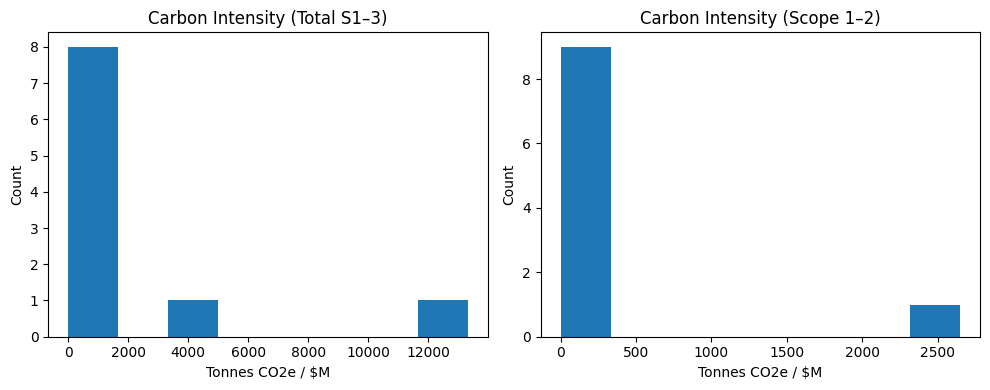

Skew (rough idea):
  Total S1–3: 2.6949553856266304
  Scope 1–2: 3.1554234147416897


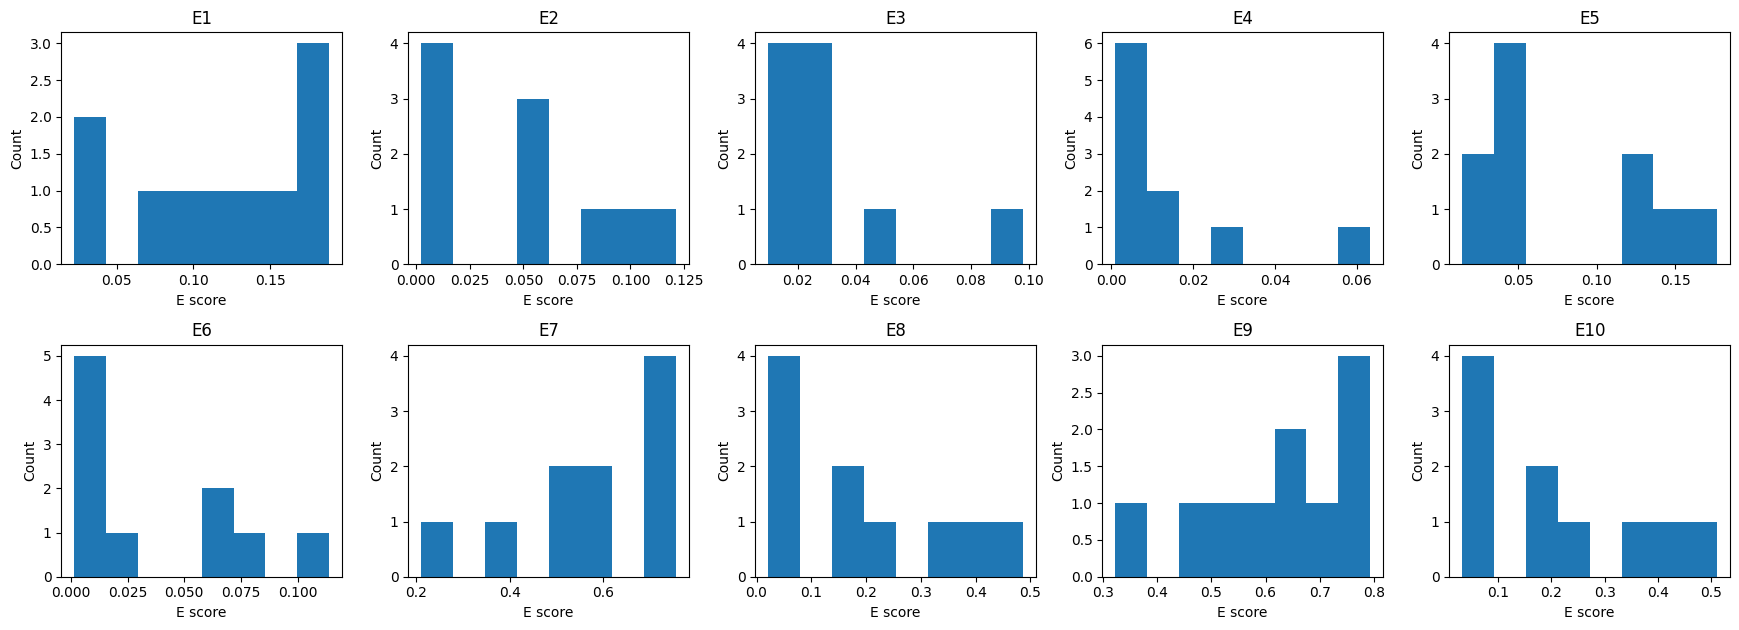

In [6]:
# 2.4 Quick visual check – are these distributions skewed?
#     I like to see a histogram for carbon (Total and 1–2) and for each E variant.

# Carbon histograms
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df["Carbon_Total"].dropna(), bins=8)
plt.title("Carbon Intensity (Total S1–3)")
plt.xlabel("Tonnes CO2e / $M"); plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(df["Carbon_wo_Scope3"].dropna(), bins=8)
plt.title("Carbon Intensity (Scope 1–2)")
plt.xlabel("Tonnes CO2e / $M"); plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Skew (rough idea):")
print("  Total S1–3:", df["Carbon_Total"].dropna().skew())
print("  Scope 1–2:", df["Carbon_wo_Scope3"].dropna().skew())

# E variant histograms (small multiples)
E_cols = [c for c in df.columns if re.fullmatch(r"E[1-9]|E10", c)]
if E_cols:
    nE = len(E_cols)
    cols_per_row = 5
    rows_needed = int(np.ceil(nE / cols_per_row))
    plt.figure(figsize=(3.5*cols_per_row, 3.2*rows_needed))
    for i, col in enumerate(E_cols, 1):
        plt.subplot(rows_needed, cols_per_row, i)
        plt.hist(df[col].dropna(), bins=8)
        plt.title(col)
        plt.xlabel("E score"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("I did not find E1..E10 columns yet. I’ll create them after I load all variants.")

### 3. Comparison: Custom ESG Scores vs. Carbon Intensity

In [7]:
# 3. Build rankings (E and Carbon)

# Here I create ranks:
# - for my E variants: higher E = better, so rank 1 = highest E
# - for carbon: lower intensity = better, so rank 1 = lowest carbon
for col in E_cols:
    df[f"{col}_rank"] = rank_desc(df[col])

df["Carbon_Total_rank"]     = rank_asc(df["Carbon_Total"])
df["Carbon_wo_Scope3_rank"] = rank_asc(df["Carbon_wo_Scope3"])

# I print a small sample to make sure ranks look ok
cols_example = ["Company",
                "Carbon_Total","Carbon_Total_rank",
                "Carbon_wo_Scope3","Carbon_wo_Scope3_rank"] + [f"{c}_rank" for c in E_cols[:3]]
print("Head (ranks preview):")
print(df[cols_example].head(10).to_string(index=False))


Head (ranks preview):
                       Company  Carbon_Total  Carbon_Total_rank  Carbon_wo_Scope3  Carbon_wo_Scope3_rank  E1_rank  E2_rank  E3_rank
                       ABB Ltd     13299.746               10.0             7.490                    6.0      2.0      2.0      2.0
Compagnie Financière Richemont        82.606                3.0             3.719                    3.0      8.0      8.0      3.0
                    Holcim Ltd      4215.455                9.0          2646.914                   10.0      1.0      1.0      1.0
                Lonza Group AG       366.637                7.0            83.536                    9.0      7.0      7.0      6.0
                     Nestlé SA      1158.483                8.0            59.112                    8.0      6.0      6.0      4.0
                   Novartis AG       127.190                6.0            12.055                    7.0     10.0     10.0      8.0
              Roche Holding AG       101.991          

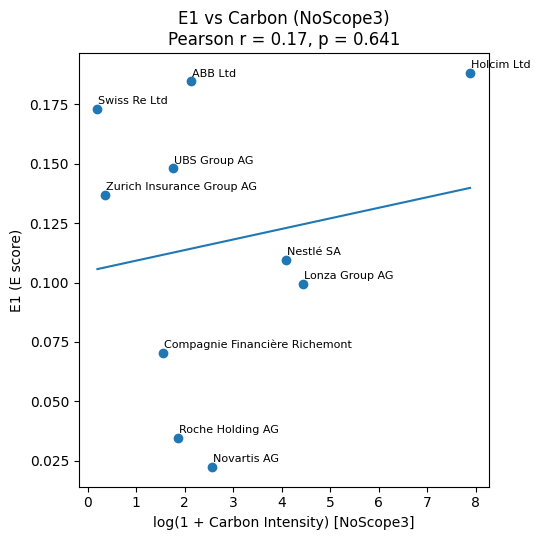

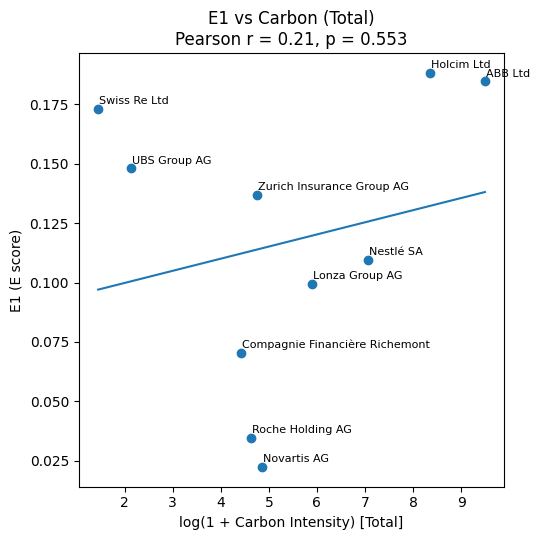

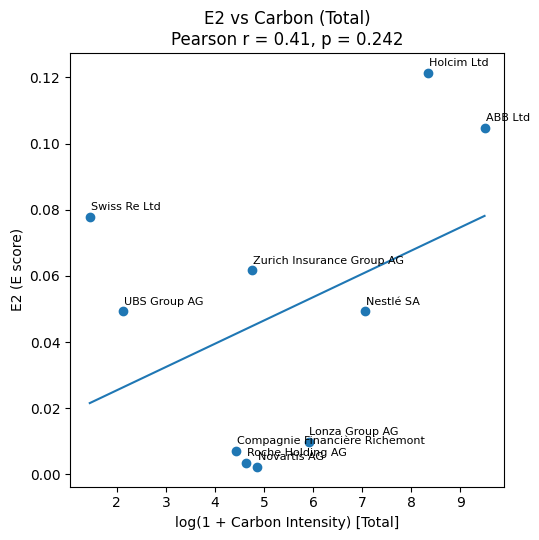

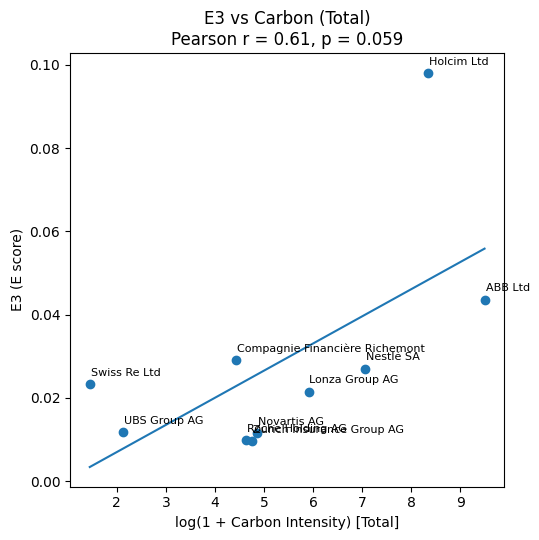

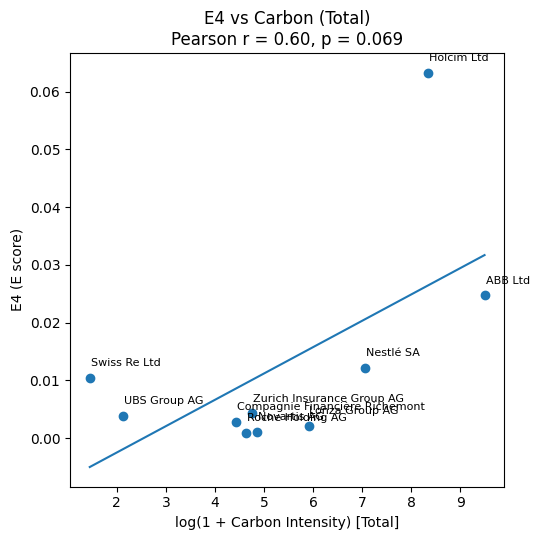

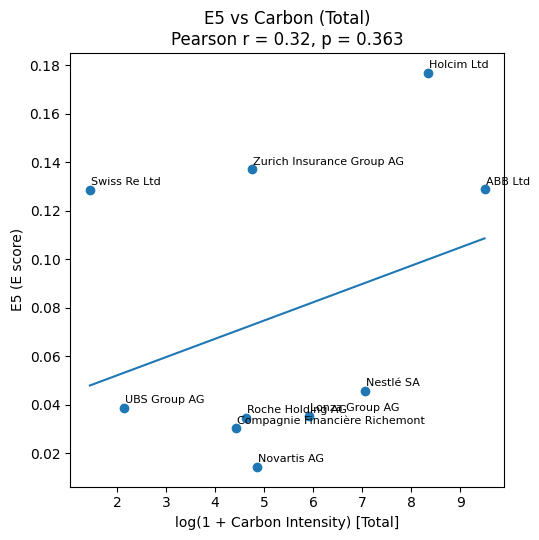

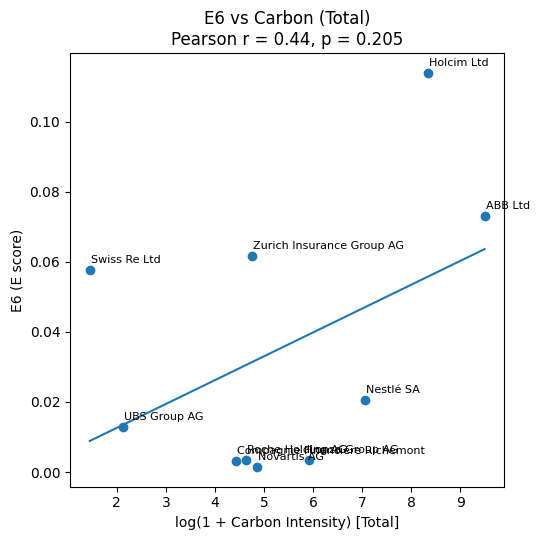

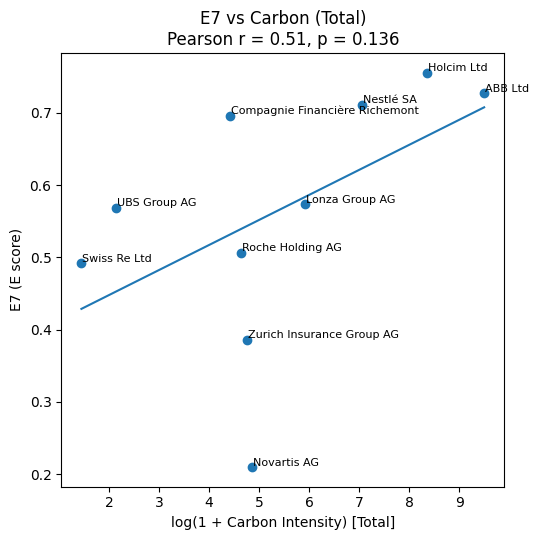

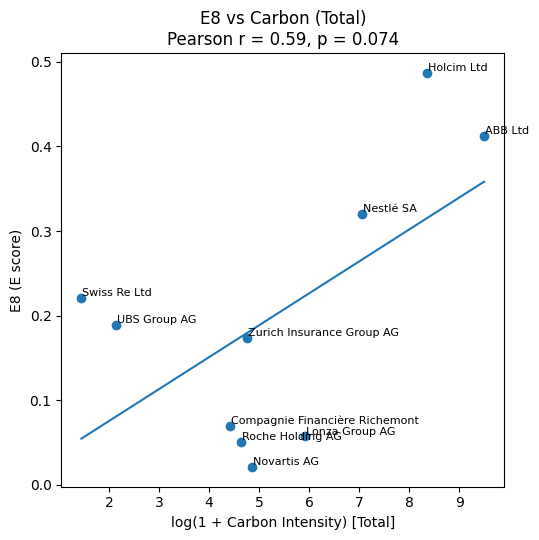

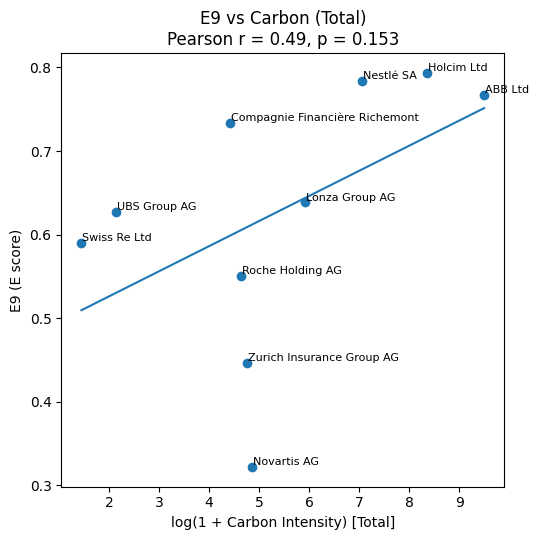

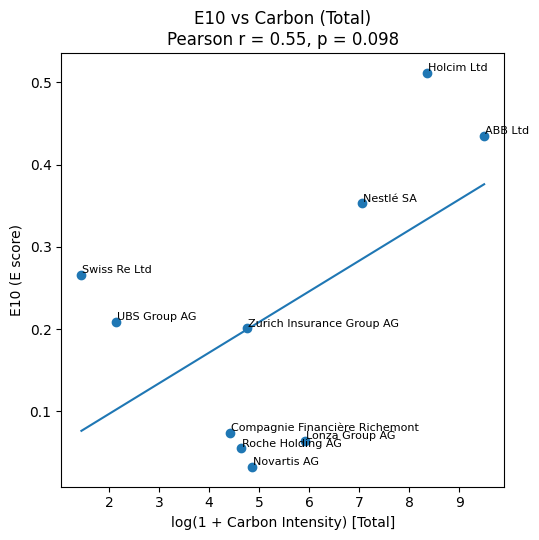

In [8]:
# 4. Visual: scatter (log carbon on X, E score on Y) + Pearson + fitted line

from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt

def scatter_and_pearson(e_variant="E6", carbon_metric="Total"):
    """
    I plot: X = log(1 + carbon), Y = my E score.
    I also draw the best-fit line and print Pearson r and p-value.
    """
    assert e_variant in E_cols, f"Unknown E variant: {e_variant}"
    xcol = "Carbon_Total_log" if carbon_metric == "Total" else "Carbon_wo_Scope3_log"
    ycol = e_variant

    m = df[xcol].notna() & df[ycol].notna()
    xs = df.loc[m, xcol]
    ys = df.loc[m, ycol]
    labs = df.loc[m, "Company"]

    if len(xs) < 3:
        print("Not enough points to plot.")
        return

    # Pearson correlation on values
    r, p = pearsonr(xs, ys)

    plt.figure(figsize=(5.5, 5.5))
    # scatter
    plt.scatter(xs, ys)

    # I add labels so I know which point is which company
    for xi, yi, lab in zip(xs, ys, labs):
        plt.text(xi + 0.02, yi + 0.002, str(lab), fontsize=8)

    # best-fit line (simple OLS)
    a, b = np.polyfit(xs, ys, 1)
    x_line = np.linspace(xs.min(), xs.max(), 100)
    y_line = a * x_line + b
    plt.plot(x_line, y_line)  # regression line

    plt.xlabel(f"log(1 + Carbon Intensity) [{carbon_metric}]")
    plt.ylabel(f"{e_variant} (E score)")
    plt.title(f"{e_variant} vs Carbon ({carbon_metric})\nPearson r = {r:.2f}, p = {p:.3f}")
    plt.tight_layout()
    plt.show()

# Examples (I keep them explicit so I can scroll the charts one by one)
scatter_and_pearson("E1", "NoScope3")
scatter_and_pearson("E1", "Total")
scatter_and_pearson("E2", "Total")
scatter_and_pearson("E3", "Total")
scatter_and_pearson("E4", "Total")
scatter_and_pearson("E5", "Total")
scatter_and_pearson("E6", "Total")
scatter_and_pearson("E7", "Total")
scatter_and_pearson("E8", "Total")
scatter_and_pearson("E9", "Total")
scatter_and_pearson("E10", "Total")


In [9]:
# 5. Part A — Compare my E scores with carbon intensity (tables)

from IPython.display import display
from scipy.stats import spearmanr, kendalltau, pearsonr
import numpy as np
import pandas as pd

# Small text I keep as a reminder of what each metric means (I print it once)
explain = """
What I measure here (simple):
- Pearson r (values): linear link between log(carbon) and my E score.
  If r is NEGATIVE → higher E when carbon is lower (good for 'low-carbon' alignment).
- Spearman rho (ranks): do the two ORDERINGS match? (1=best on both sides)
  Higher is better (closer to ‘lowest carbon’ ranking).
- Kendall tau-b (ranks): same idea as Spearman, a bit more robust with ties.
- MAR (Mean Absolute Rank Error): on average, how many rank positions apart the two rankings are.
  Lower is better.
- Jaccard@k: overlap between my top-k E companies and the top-k lowest carbon companies (0=no overlap, 1=perfect).
"""
print(explain)

def summarize_e_vs_carbon(carbon="Total", k=3):
    """
    For each E variant (E1..E10), I compare my E ranking vs the carbon ranking.
    I show:
      - Pearson r (log carbon vs E, values)
      - Spearman/Kendall (ranks)
      - MAR (mean absolute rank gap)
      - Jaccard@k (top-k overlap: top E vs top lowest-carbon)
    """
    assert carbon in {"Total", "NoScope3"}
    carb_col  = "Carbon_Total" if carbon == "Total" else "Carbon_wo_Scope3"
    carb_log  = "Carbon_Total_log" if carbon == "Total" else "Carbon_wo_Scope3_log"

    rows = []
    for e in [c for c in df.columns if c.startswith("E") and not c.endswith("_rank")]:
        # ranks (I compute them locally so it's self-contained)
        e_rank = df[e].rank(ascending=False, method="min")        # higher E = better (rank 1)
        c_rank = df[carb_col].rank(ascending=True, method="min")  # lower carbon = better (rank 1)

        m = df[e].notna() & df[carb_col].notna() & df[carb_log].notna()
        n = int(m.sum())
        if n < 3:
            rows.append({"E_variant": e, "n": n,
                         "pearson_logX": np.nan, "pearson_p": np.nan,
                         "spearman": np.nan, "spearman_p": np.nan,
                         "kendall": np.nan, "kendall_p": np.nan,
                         "MAR_ranks": np.nan, "Jaccard@k": np.nan})
            continue

        # values (Pearson on log carbon vs raw E)
        r_lin, p_lin = pearsonr(df.loc[m, carb_log], df.loc[m, e])

        # ranks (Spearman/Kendall on the rank series)
        rho, p_rho = spearmanr(e_rank[m], c_rank[m])
        tau, p_tau = kendalltau(e_rank[m], c_rank[m])

        # MAR
        mar = (e_rank[m] - c_rank[m]).abs().mean()

        # Jaccard@k (top E vs top lowest carbon)
        sub = df.loc[m, ["Company", e, carb_col]].copy()
        top_e   = set(sub.sort_values(by=e, ascending=False)["Company"].head(k))
        top_low = set(sub.sort_values(by=carb_col, ascending=True)["Company"].head(k))
        jaccard = len(top_e & top_low) / len(top_e | top_low) if len(top_e | top_low) > 0 else np.nan

        rows.append({
            "E_variant": e,
            "n": n,
            "pearson_logX": r_lin, "pearson_p": p_lin,
            "spearman": rho, "spearman_p": p_rho,
            "kendall": tau, "kendall_p": p_tau,
            "MAR_ranks": mar,
            "Jaccard@k": jaccard
        })

    out = pd.DataFrame(rows)

    # I show two clean tables:
    # 1) By rank agreement (closer to lowest carbon): Spearman ↓ sorted, Kendall ↓, MAR ↑ reversed
    t_rank = (out.sort_values(["spearman", "kendall", "MAR_ranks"],
                              ascending=[False, False, True])
                .reset_index(drop=True)
                .round({"pearson_logX":3, "spearman":3, "kendall":3, "MAR_ranks":2, "Jaccard@k":3}))
    print(f"\nA — E vs carbon ({carbon}) — best by rank agreement (higher Spearman/Kendall, lower MAR):")
    display(t_rank[["E_variant","n","spearman","spearman_p","kendall","kendall_p","MAR_ranks","Jaccard@k","pearson_logX","pearson_p"]])

    # 2) By Pearson (values). Note: more NEGATIVE = higher E when carbon is lower.
    t_pear = (out.sort_values(["pearson_logX","MAR_ranks"],
                              ascending=[True, True])  # more negative first, then lower MAR
                .reset_index(drop=True)
                .round({"pearson_logX":3, "spearman":3, "kendall":3, "MAR_ranks":2, "Jaccard@k":3}))
    print(f"\nB — E vs carbon ({carbon}) — best by Pearson on values (more negative is better for low-carbon):")
    display(t_pear[["E_variant","n","pearson_logX","pearson_p","spearman","kendall","MAR_ranks","Jaccard@k"]])

    return t_rank, t_pear

# I run for Scope 1–3 and Scope 1–2
summary_e_total_rank, summary_e_total_pear = summarize_e_vs_carbon("Total",   k=3)
summary_e_noscope_rank, summary_e_noscope_pear = summarize_e_vs_carbon("NoScope3", k=3)



What I measure here (simple):
- Pearson r (values): linear link between log(carbon) and my E score.
  If r is NEGATIVE → higher E when carbon is lower (good for 'low-carbon' alignment).
- Spearman rho (ranks): do the two ORDERINGS match? (1=best on both sides)
  Higher is better (closer to ‘lowest carbon’ ranking).
- Kendall tau-b (ranks): same idea as Spearman, a bit more robust with ties.
- MAR (Mean Absolute Rank Error): on average, how many rank positions apart the two rankings are.
  Lower is better.
- Jaccard@k: overlap between my top-k E companies and the top-k lowest carbon companies (0=no overlap, 1=perfect).


A — E vs carbon (Total) — best by rank agreement (higher Spearman/Kendall, lower MAR):


,E_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
0,E1,10,-0.248,0.488776,-0.111,0.727490,3.6,0.2,0.214,0.553078
1,E2,10,-0.285,0.425038,-0.156,0.600654,3.8,0.2,0.408,0.241598
2,E5,10,-0.358,0.310376,-0.244,0.380720,4.2,0.0,0.323,0.362708
3,E8,10,-0.394,0.259998,-0.200,0.484313,4.2,0.0,0.588,0.074022
4,E10,10,-0.394,0.259998,-0.200,0.484313,4.2,0.0,0.551,0.098472
5,E6,10,-0.418,0.229113,-0.289,0.291248,4.2,0.0,0.438,0.205488
6,E4,10,-0.455,0.186905,-0.289,0.291248,4.2,0.0,0.596,0.069100
7,E3,10,-0.455,0.186905,-0.333,0.216373,4.2,0.2,0.614,0.059047
8,E9,10,-0.539,0.107593,-0.333,0.216373,4.6,0.0,0.488,0.152902
9,E7,10,-0.600,0.066688,-0.422,0.108313,4.6,0.0,0.505,0.136490



B — E vs carbon (Total) — best by Pearson on values (more negative is better for low-carbon):


,E_variant,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,E1,10,0.214,0.553078,-0.248,-0.111,3.6,0.2
1,E5,10,0.323,0.362708,-0.358,-0.244,4.2,0.0
2,E2,10,0.408,0.241598,-0.285,-0.156,3.8,0.2
3,E6,10,0.438,0.205488,-0.418,-0.289,4.2,0.0
4,E9,10,0.488,0.152902,-0.539,-0.333,4.6,0.0
5,E7,10,0.505,0.136490,-0.600,-0.422,4.6,0.0
6,E10,10,0.551,0.098472,-0.394,-0.200,4.2,0.0
7,E8,10,0.588,0.074022,-0.394,-0.200,4.2,0.0
8,E4,10,0.596,0.069100,-0.455,-0.289,4.2,0.0
9,E3,10,0.614,0.059047,-0.455,-0.333,4.2,0.2



A — E vs carbon (NoScope3) — best by rank agreement (higher Spearman/Kendall, lower MAR):


,E_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
0,E2,10,0.006,0.986743,0.067,0.861801,3.4,0.2,0.300,0.400046
1,E1,10,-0.018,0.960240,0.022,1.000000,3.4,0.2,0.169,0.640513
2,E5,10,-0.030,0.933773,-0.022,1.000000,3.4,0.2,0.196,0.586478
3,E6,10,-0.079,0.828717,-0.067,0.861801,3.6,0.2,0.352,0.318838
4,E4,10,-0.152,0.676065,-0.067,0.861801,3.8,0.0,0.740,0.014461
5,E8,10,-0.152,0.676065,-0.067,0.861801,3.8,0.0,0.484,0.156419
6,E10,10,-0.152,0.676065,-0.067,0.861801,3.8,0.0,0.452,0.190072
7,E3,10,-0.382,0.276255,-0.289,0.291248,4.0,0.2,0.781,0.007669
8,E9,10,-0.515,0.127553,-0.378,0.155742,4.4,0.0,0.477,0.163417
9,E7,10,-0.539,0.107593,-0.378,0.155742,4.4,0.0,0.468,0.172190



B — E vs carbon (NoScope3) — best by Pearson on values (more negative is better for low-carbon):


,E_variant,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,E1,10,0.169,0.640513,-0.018,0.022,3.4,0.2
1,E5,10,0.196,0.586478,-0.030,-0.022,3.4,0.2
2,E2,10,0.300,0.400046,0.006,0.067,3.4,0.2
3,E6,10,0.352,0.318838,-0.079,-0.067,3.6,0.2
4,E10,10,0.452,0.190072,-0.152,-0.067,3.8,0.0
5,E7,10,0.468,0.172190,-0.539,-0.378,4.4,0.0
6,E9,10,0.477,0.163417,-0.515,-0.378,4.4,0.0
7,E8,10,0.484,0.156419,-0.152,-0.067,3.8,0.0
8,E4,10,0.740,0.014461,-0.152,-0.067,3.8,0.0
9,E3,10,0.781,0.007669,-0.382,-0.289,4.0,0.2


In [10]:
# 6. Build my ESG totals (df1_* -> ESG1, ..., df10_* -> ESG10) and compare to carbon

# I assume I already ran the carbon cell (it created `carb_year` with 2022 carbon data).
if "carb_year" not in globals():
    raise RuntimeError("I need `carb_year` from the carbon loading step. Run that cell first.")

import os, re
import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import spearmanr, kendalltau, pearsonr

# 6.1 Load TOTAL ESG with a fixed mapping:
#     df1_* -> ESG1, df2_* -> ESG2, ..., df10_* -> ESG10
def pick_esg_total_col(df):
    # I prefer a clean total column; I keep it simple.
    for c in ["ESG_total", "ESG_score", "ESG"]:
        if c in df.columns:
            return c
    # last resort: any column starting with 'ESG' but not per-pillar
    for c in df.columns:
        cl = c.lower()
        if cl.startswith("esg") and cl not in {"esg_e", "esg_s", "esg_g"}:
            return c
    return None

# I only keep files that look like dfN_*.csv (N = 1..10)
indexed_files = []
for fname in os.listdir(scores_path):
    if fname.lower().endswith(".csv"):
        m = re.match(r"^df(\d+)_", fname)
        if m:
            num = int(m.group(1))
            if 1 <= num <= 10:
                indexed_files.append((num, fname))
indexed_files = sorted(indexed_files, key=lambda x: x[0])

rows = []
manifest_rows = []  # so I can see exactly what feeds each ESGk

for v, fname in indexed_files:
    path = os.path.join(scores_path, fname)
    try:
        tmp = pd.read_csv(path)
    except Exception:
        continue

    # I need at least company/year
    if not {"company", "year"}.issubset(tmp.columns):
        continue

    tcol = pick_esg_total_col(tmp)
    if tcol is None:
        # this file doesn’t have a total ESG column; I skip it
        continue

    # keep my target year and one total ESG column
    sub = tmp.loc[tmp["year"] == year, ["company", "year", tcol]].copy()
    sub = sub.rename(columns={"company": "Company", tcol: "ESG_value"})
    sub["variant"] = v
    rows.append(sub)

    # log what I used (file + column) so ESGk is crystal clear
    manifest_rows.append({"ESG_variant": f"ESG{v}", "file": fname, "ESG_total_column_used": tcol})

if not rows:
    raise RuntimeError("I couldn't find any TOTAL ESG column in my dfN_* CSVs.")

ESG_all = pd.concat(rows, ignore_index=True)

# pivot to wide: Company × ESG1..ESG10
ESG_year = (
    ESG_all
      .pivot_table(index="Company", columns="variant", values="ESG_value", aggfunc="first")
      .reset_index()
)
ESG_year = ESG_year.rename(columns={c: f"ESG{int(c)}" for c in ESG_year.columns if isinstance(c, (int, np.integer))})

print(f"My ESG totals ({year}) – shape:", ESG_year.shape)
display(ESG_year.head())

# little manifest (this is what ESG1..ESG10 mean)
esg_manifest = pd.DataFrame(manifest_rows).sort_values("ESG_variant").reset_index(drop=True)
print("ESG variant manifest (source file + column used):")
display(esg_manifest)

# merge with carbon (same companies, same year)
df_esg = carb_year.merge(ESG_year, on="Company", how="inner")
print("Merged (Carbon + ESG totals) – companies in common:", df_esg["Company"].nunique())
display(df_esg.head())

# 6.2 Quick reminder for me: how I read the metrics below
print("""
What I measure here (quick notes):
- Pearson r (values): linear link between log(carbon) and my ESG total.
  If r is NEGATIVE → higher ESG when carbon is lower (good for 'low-carbon' alignment).
- Spearman rho (ranks): do the two ORDERINGS match? (1=best on both sides). Higher is better.
- Kendall tau-b (ranks): similar idea, robust with ties. Higher is better.
- MAR (Mean Absolute Rank Error): average distance in ranks. Lower is better.
- Jaccard@k: overlap between my top-k ESG and top-k lowest-carbon companies (0 to 1).
""")

# 6.3 Tables per variant: ESG vs carbon (Total or NoScope3)
def summarize_esg_vs_carbon(carbon="Total", k=3):
    """
    For each ESG variant (ESG1..ESG10), I compare my ESG ranking vs the carbon ranking.
    I show:
      - Pearson (log carbon vs ESG total, values)
      - Spearman/Kendall (ranks)
      - MAR (rank gap)
      - Jaccard@k (top-k overlap: top ESG vs top lowest-carbon)
    """
    assert carbon in {"Total", "NoScope3"}
    carb_col = "Carbon_Total" if carbon == "Total" else "Carbon_wo_Scope3"
    carb_log = "Carbon_Total_log" if carbon == "Total" else "Carbon_wo_Scope3_log"

    variants = [c for c in df_esg.columns if c.startswith("ESG") and not c.endswith("_rank")]
    rows = []

    for v in variants:
        # ranks (I recompute locally so this function is standalone)
        v_rank = df_esg[v].rank(ascending=False, method="min")       # higher ESG = better
        c_rank = df_esg[carb_col].rank(ascending=True, method="min") # lower carbon = better

        m = df_esg[v].notna() & df_esg[carb_col].notna() & df_esg[carb_log].notna()
        n = int(m.sum())
        if n < 3:
            rows.append({"ESG_variant": v, "n": n,
                         "pearson_logX": np.nan, "pearson_p": np.nan,
                         "spearman": np.nan, "spearman_p": np.nan,
                         "kendall": np.nan, "kendall_p": np.nan,
                         "MAR_ranks": np.nan, "Jaccard@k": np.nan})
            continue

        # values: Pearson on log(carbon) vs ESG
        r_lin, p_lin = pearsonr(df_esg.loc[m, carb_log], df_esg.loc[m, v])

        # ranks
        rho, p_rho = spearmanr(v_rank[m], c_rank[m])
        tau, p_tau = kendalltau(v_rank[m], c_rank[m])

        mar = (v_rank[m] - c_rank[m]).abs().mean()

        # top-k overlap (top ESG vs top lowest-carbon)
        sub = df_esg.loc[m, ["Company", v, carb_col]].copy()
        top_esg = set(sub.sort_values(by=v, ascending=False)["Company"].head(k))
        top_low = set(sub.sort_values(by=carb_col, ascending=True)["Company"].head(k))
        jaccard = len(top_esg & top_low) / len(top_esg | top_low) if len(top_esg | top_low) > 0 else np.nan

        rows.append({
            "ESG_variant": v,
            "n": n,
            "pearson_logX": r_lin, "pearson_p": p_lin,
            "spearman": rho, "spearman_p": p_rho,
            "kendall": tau, "kendall_p": p_tau,
            "MAR_ranks": mar,
            "Jaccard@k": jaccard
        })

    out = pd.DataFrame(rows)

    # Table A — by rank agreement (Spearman/Kendall high, MAR low)
    t_rank = (out.sort_values(["spearman", "kendall", "MAR_ranks"],
                              ascending=[False, False, True])
                .reset_index(drop=True)
                .round({"pearson_logX": 3, "spearman": 3, "kendall": 3,
                        "MAR_ranks": 2, "Jaccard@k": 3}))
    print(f"\nESG(total) vs carbon ({carbon}) — best by rank agreement:")
    display(t_rank[["ESG_variant", "n",
                    "spearman", "spearman_p",
                    "kendall", "kendall_p",
                    "MAR_ranks", "Jaccard@k",
                    "pearson_logX", "pearson_p"]])

    # Table B — by Pearson (more negative is better for low-carbon)
    t_pear = (out.sort_values(["pearson_logX", "MAR_ranks"],
                              ascending=[True, True])
                .reset_index(drop=True)
                .round({"pearson_logX": 3, "spearman": 3, "kendall": 3,
                        "MAR_ranks": 2, "Jaccard@k": 3}))
    print(f"\nESG(total) vs carbon ({carbon}) — best by Pearson (more negative is better):")
    display(t_pear[["ESG_variant", "n",
                    "pearson_logX", "pearson_p",
                    "spearman", "kendall",
                    "MAR_ranks", "Jaccard@k"]])

    return t_rank, t_pear

# 6.4 I run it for both carbon metrics
summary_esg_total_rank,   summary_esg_total_pear   = summarize_esg_vs_carbon("Total",   k=3)
summary_esg_noscope_rank, summary_esg_noscope_pear = summarize_esg_vs_carbon("NoScope3", k=3)


My ESG totals (2022) – shape: (10, 11)


variant,Company,ESG1,ESG2,ESG3,ESG4,ESG5,ESG6,ESG7,ESG8,ESG9,ESG10
0,ABB Ltd,0.109693,0.136015,0.020308,0.028472,0.074099,0.093254,0.624445,0.660796,0.642113,0.686476
1,Compagnie Financière Richemont,0.072407,0.083839,0.027183,0.032516,0.037893,0.043817,0.582110,0.608868,0.607595,0.630060
2,Holcim Ltd,0.094225,0.138134,0.038647,0.066408,0.086867,0.128841,0.541680,0.641559,0.573041,0.676008
3,Lonza Group AG,0.086245,0.097356,0.014345,0.015204,0.044540,0.052567,0.553411,0.655471,0.583997,0.669283
4,Nestlé SA,0.080415,0.094744,0.023548,0.027973,0.033052,0.039559,0.590447,0.643832,0.623198,0.684154


ESG variant manifest (source file + column used):


,ESG_variant,file,ESG_total_column_used
0,ESG1,df1_ESG_quantity.csv,ESG_total
1,ESG10,df10_Pos_only_SASB.csv,ESG_total
2,ESG2,df2_ESG_quantity_SASB.csv,ESG_total
3,ESG3,df3_ESG_earnings.csv,ESG_total
4,ESG4,df4_ESG_earnings_SASB.csv,ESG_total
5,ESG5,df5_ESG_no_comm.csv,ESG_total
6,ESG6,df6_ESG_no_comm_SASB.csv,ESG_total
7,ESG7,df7_Pos_minus_Neg.csv,ESG_total
8,ESG8,df8_Pos_minus_Neg_SASB.csv,ESG_total
9,ESG9,df9_Pos_only.csv,ESG_total


Merged (Carbon + ESG totals) – companies in common: 10


,Company,Carbon_Total,Carbon_wo_Scope3,Carbon_Total_log,Carbon_wo_Scope3_log,ESG1,ESG2,ESG3,ESG4,ESG5,ESG6,ESG7,ESG8,ESG9,ESG10
0,ABB Ltd,13299.746,7.490,9.495575,2.138889,0.109693,0.136015,0.020308,0.028472,0.074099,0.093254,0.624445,0.660796,0.642113,0.686476
1,Compagnie Financière Richemont,82.606,3.719,4.426115,1.551597,0.072407,0.083839,0.027183,0.032516,0.037893,0.043817,0.582110,0.608868,0.607595,0.630060
2,Holcim Ltd,4215.455,2646.914,8.346750,7.881527,0.094225,0.138134,0.038647,0.066408,0.086867,0.128841,0.541680,0.641559,0.573041,0.676008
3,Lonza Group AG,366.637,83.536,5.907096,4.437177,0.086245,0.097356,0.014345,0.015204,0.044540,0.052567,0.553411,0.655471,0.583997,0.669283
4,Nestlé SA,1158.483,59.112,7.055729,4.096209,0.080415,0.094744,0.023548,0.027973,0.033052,0.039559,0.590447,0.643832,0.623198,0.684154



What I measure here (quick notes):
- Pearson r (values): linear link between log(carbon) and my ESG total.
  If r is NEGATIVE → higher ESG when carbon is lower (good for 'low-carbon' alignment).
- Spearman rho (ranks): do the two ORDERINGS match? (1=best on both sides). Higher is better.
- Kendall tau-b (ranks): similar idea, robust with ties. Higher is better.
- MAR (Mean Absolute Rank Error): average distance in ranks. Lower is better.
- Jaccard@k: overlap between my top-k ESG and top-k lowest-carbon companies (0 to 1).


ESG(total) vs carbon (Total) — best by rank agreement:


,ESG_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
0,ESG1,10,-0.176,0.627188,-0.111,0.727490,3.6,0.2,0.252,0.483266
1,ESG5,10,-0.248,0.488776,-0.156,0.600654,4.0,0.0,0.277,0.439024
2,ESG6,10,-0.297,0.404702,-0.200,0.484313,3.8,0.0,0.415,0.232672
3,ESG7,10,-0.358,0.310376,-0.244,0.380720,4.0,0.2,0.319,0.369035
4,ESG9,10,-0.358,0.310376,-0.244,0.380720,4.0,0.2,0.318,0.369867
5,ESG3,10,-0.394,0.259998,-0.244,0.380720,4.4,0.2,0.590,0.072724
6,ESG4,10,-0.418,0.229113,-0.289,0.291248,4.4,0.2,0.613,0.059642
7,ESG2,10,-0.467,0.173939,-0.289,0.291248,4.4,0.2,0.448,0.193694
8,ESG8,10,-0.648,0.042540,-0.467,0.072550,4.8,0.0,0.526,0.118649
9,ESG10,10,-0.685,0.028883,-0.556,0.028609,4.8,0.0,0.544,0.103960



ESG(total) vs carbon (Total) — best by Pearson (more negative is better):


,ESG_variant,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,ESG1,10,0.252,0.483266,-0.176,-0.111,3.6,0.2
1,ESG5,10,0.277,0.439024,-0.248,-0.156,4.0,0.0
2,ESG9,10,0.318,0.369867,-0.358,-0.244,4.0,0.2
3,ESG7,10,0.319,0.369035,-0.358,-0.244,4.0,0.2
4,ESG6,10,0.415,0.232672,-0.297,-0.200,3.8,0.0
5,ESG2,10,0.448,0.193694,-0.467,-0.289,4.4,0.2
6,ESG8,10,0.526,0.118649,-0.648,-0.467,4.8,0.0
7,ESG10,10,0.544,0.103960,-0.685,-0.556,4.8,0.0
8,ESG3,10,0.590,0.072724,-0.394,-0.244,4.4,0.2
9,ESG4,10,0.613,0.059642,-0.418,-0.289,4.4,0.2



ESG(total) vs carbon (NoScope3) — best by rank agreement:


,ESG_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
0,ESG6,10,0.042,0.907364,0.022,1.000000,3.0,0.2,0.312,0.379425
1,ESG1,10,0.042,0.907364,0.022,1.000000,3.4,0.2,0.113,0.756467
2,ESG5,10,0.030,0.933773,-0.022,1.000000,3.2,0.2,0.098,0.788425
3,ESG7,10,-0.236,0.510885,-0.111,0.727490,3.8,0.2,0.166,0.645887
4,ESG9,10,-0.236,0.510885,-0.111,0.727490,3.8,0.2,0.193,0.592939
5,ESG2,10,-0.273,0.445838,-0.156,0.600654,4.2,0.2,0.334,0.344808
6,ESG4,10,-0.418,0.229113,-0.244,0.380720,4.2,0.2,0.774,0.008626
7,ESG3,10,-0.442,0.200423,-0.289,0.291248,4.2,0.2,0.721,0.018615
8,ESG8,10,-0.576,0.081553,-0.422,0.108313,4.6,0.0,0.483,0.157123
9,ESG10,10,-0.576,0.081553,-0.422,0.108313,4.6,0.0,0.517,0.125815



ESG(total) vs carbon (NoScope3) — best by Pearson (more negative is better):


,ESG_variant,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,ESG5,10,0.098,0.788425,0.030,-0.022,3.2,0.2
1,ESG1,10,0.113,0.756467,0.042,0.022,3.4,0.2
2,ESG7,10,0.166,0.645887,-0.236,-0.111,3.8,0.2
3,ESG9,10,0.193,0.592939,-0.236,-0.111,3.8,0.2
4,ESG6,10,0.312,0.379425,0.042,0.022,3.0,0.2
5,ESG2,10,0.334,0.344808,-0.273,-0.156,4.2,0.2
6,ESG8,10,0.483,0.157123,-0.576,-0.422,4.6,0.0
7,ESG10,10,0.517,0.125815,-0.576,-0.422,4.6,0.0
8,ESG3,10,0.721,0.018615,-0.442,-0.289,4.2,0.2
9,ESG4,10,0.774,0.008626,-0.418,-0.244,4.2,0.2


### 4. Comparison: Custom ESG Scores vs. Refinitiv ESG Scores

In [11]:
# 7. Compare my ESG scores to Refinitiv (2022)

# I need my ESG variants table (ESG_year) and the Excel path + year.
if "ESG_year" not in globals():
    raise RuntimeError("I need `ESG_year` (Company × ESG1..ESG10). Build it first (section 6).")
if "refinitiv_path" not in globals():
    raise RuntimeError("I need `refinitiv_path` pointing to 'SMI companies.xlsx'.")
if "year" not in globals():
    raise RuntimeError("I need the `year` variable (e.g., 2022).")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import pearsonr, spearmanr, kendalltau

# Small helpers (I keep them here in case I run this cell alone)
def parse_comma_float(x):
    # I convert '94,00' -> 94.00 etc.
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.number)): return float(x)
    s = str(x).strip().replace(" ", "")
    s = s.replace(".", "").replace(",", ".")
    try: return float(s)
    except: return np.nan

def rank_desc(s):
    # Rank where higher is better (1 = highest)
    return s.rank(ascending=False, method="min")

def mean_abs_rank_error(r1, r2):
    # On average, how many rank positions apart?
    m = r1.notna() & r2.notna()
    if m.sum() == 0: return np.nan
    return (r1[m] - r2[m]).abs().mean()

def jaccard_topk(a, b):
    # Overlap between two sets (0..1)
    u = a | b
    return len(a & b) / len(u) if len(u) else np.nan

In [12]:
# 7.1 Load Refinitiv ESG (2022)
ref = pd.read_excel(refinitiv_path, sheet_name="Refinitiv ESG")
ref = ref.rename(columns={
    "company": "Company",
    "year": "year",
    "ESG Score": "Ref_ESG",
    "ESG Combined Score": "Ref_ESGC",
})
ref["Company"] = ref["Company"].astype(str).str.strip()
ref["year"] = ref["year"].astype(int)
for c in ["Ref_ESG", "Ref_ESGC"]:
    ref[c] = ref[c].apply(parse_comma_float)

ref22 = ref.loc[ref["year"] == year, ["Company", "Ref_ESG", "Ref_ESGC"]].copy()

print(f"Refinitiv ESG ({year}) — shape:", ref22.shape)
display(ref22.head(10))

Refinitiv ESG (2022) — shape: (10, 3)


,Company,Ref_ESG,Ref_ESGC
1,ABB Ltd,91.0,77.0
4,Compagnie Financière Richemont,76.0,76.0
7,Holcim Ltd,79.0,79.0
10,Lonza Group AG,81.0,78.0
13,Nestlé SA,88.0,47.0
16,Novartis AG,90.0,67.0
19,Roche Holding AG,92.0,92.0
22,Swiss Re Ltd,80.0,51.0
25,UBS Group AG,87.0,48.0
28,Zurich Insurance Group AG,88.0,77.0


In [13]:
# 7.2 Merge my ESG variants with Refinitiv (same companies, same year)
df_ref = ESG_year.merge(ref22, on="Company", how="inner")
# Keep the list of my ESG variant columns
ESG_cols = [c for c in df_ref.columns if c.startswith("ESG") and c[3:].isdigit()]

# Build ranks (1 = better on both sides)
for v in ESG_cols:
    df_ref[f"{v}_rank"] = rank_desc(df_ref[v])
df_ref["Ref_ESG_rank"]  = rank_desc(df_ref["Ref_ESG"])
df_ref["Ref_ESGC_rank"] = rank_desc(df_ref["Ref_ESGC"])

print("Merged (my ESG vs Refinitiv) — companies in common:", df_ref["Company"].nunique())
display(df_ref.head())

Merged (my ESG vs Refinitiv) — companies in common: 10


,Company,ESG1,ESG2,ESG3,ESG4,ESG5,ESG6,ESG7,ESG8,ESG9,...,ESG3_rank,ESG4_rank,ESG5_rank,ESG6_rank,ESG7_rank,ESG8_rank,ESG9_rank,ESG10_rank,Ref_ESG_rank,Ref_ESGC_rank
0,ABB Ltd,0.109693,0.136015,0.020308,0.028472,0.074099,0.093254,0.624445,0.660796,0.642113,...,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,2.0,4.0
1,Compagnie Financière Richemont,0.072407,0.083839,0.027183,0.032516,0.037893,0.043817,0.582110,0.608868,0.607595,...,2.0,2.0,8.0,7.0,3.0,6.0,3.0,6.0,10.0,6.0
2,Holcim Ltd,0.094225,0.138134,0.038647,0.066408,0.086867,0.128841,0.541680,0.641559,0.573041,...,1.0,1.0,1.0,1.0,6.0,4.0,6.0,3.0,9.0,2.0
3,Lonza Group AG,0.086245,0.097356,0.014345,0.015204,0.044540,0.052567,0.553411,0.655471,0.583997,...,5.0,5.0,5.0,6.0,5.0,2.0,5.0,4.0,7.0,3.0
4,Nestlé SA,0.080415,0.094744,0.023548,0.027973,0.033052,0.039559,0.590447,0.643832,0.623198,...,3.0,4.0,9.0,8.0,2.0,3.0,2.0,2.0,4.0,10.0


In [14]:
# 7.3 Summary tables: which of my ESG variants are closest to Refinitiv?
#     What I show (quick reading guide):
#     - Pearson r (values): linear link between my ESG (0–1) and Refinitiv (0–100). Higher POSITIVE = closer.
#     - Spearman/Kendall (ranks): do the ORDERINGS match? Higher = closer.
#     - MAR: average distance in ranks. Lower = closer.
#     - Jaccard@k: overlap of top-k (my top ESG vs Refinitiv top ESG). Higher = closer.

def summarize_vs_ref(ref_col="Ref_ESG", k=3, show=True):
    assert ref_col in {"Ref_ESG", "Ref_ESGC"}
    ref_rank = f"{ref_col}_rank"

    rows = []
    for v in ESG_cols:
        vr = f"{v}_rank"
        m = df_ref[v].notna() & df_ref[ref_col].notna()
        n = int(m.sum())
        if n < 3:
            rows.append({"ESG_variant": v, "n": n,
                         "pearson_r": np.nan, "pearson_p": np.nan,
                         "spearman": np.nan, "spearman_p": np.nan,
                         "kendall": np.nan, "kendall_p": np.nan,
                         "MAR_ranks": np.nan, "Jaccard@k": np.nan})
            continue

        # Pearson on values (my ESG 0–1 vs Ref 0–100 — scale difference is fine for Pearson)
        r_lin, p_lin = pearsonr(df_ref.loc[m, v], df_ref.loc[m, ref_col])

        # Rank concordance
        rho, p_rho = spearmanr(df_ref.loc[m, vr], df_ref.loc[m, ref_rank])
        tau, p_tau = kendalltau(df_ref.loc[m, vr], df_ref.loc[m, ref_rank])

        mar = mean_abs_rank_error(df_ref[vr], df_ref[ref_rank])

        # Top-k overlap (top my ESG vs top Ref ESG)
        sub = df_ref.loc[m, ["Company", v, ref_col]].copy()
        top_mine = set(sub.sort_values(by=v, ascending=False)["Company"].head(k))
        top_ref  = set(sub.sort_values(by=ref_col, ascending=False)["Company"].head(k))
        jac = jaccard_topk(top_mine, top_ref)

        rows.append({
            "ESG_variant": v,
            "n": n,
            "pearson_r": r_lin, "pearson_p": p_lin,
            "spearman": rho, "spearman_p": p_rho,
            "kendall": tau, "kendall_p": p_tau,
            "MAR_ranks": mar,
            "Jaccard@k": jac
        })

    out = pd.DataFrame(rows)

    # Table A — closest by rank agreement (Spearman/Kendall high, MAR low)
    t_rank = (out.sort_values(["spearman", "kendall", "MAR_ranks"],
                              ascending=[False, False, True])
                .reset_index(drop=True)
                .round({"pearson_r":3, "spearman":3, "kendall":3, "MAR_ranks":2, "Jaccard@k":3}))

    # Table B — closest by Pearson on values (higher positive is better)
    t_pear = (out.sort_values(["pearson_r", "MAR_ranks"],
                              ascending=[False, True])
                .reset_index(drop=True)
                .round({"pearson_r":3, "spearman":3, "kendall":3, "MAR_ranks":2, "Jaccard@k":3}))

    if show:
        print(f"\nA — My ESG vs {ref_col} ({year}) — best by rank agreement:")
        display(t_rank[["ESG_variant","n","spearman","spearman_p","kendall","kendall_p","MAR_ranks","Jaccard@k","pearson_r","pearson_p"]])

        print(f"\nB — My ESG vs {ref_col} ({year}) — best by Pearson (values):")
        display(t_pear[["ESG_variant","n","pearson_r","pearson_p","spearman","kendall","MAR_ranks","Jaccard@k"]])

    return t_rank, t_pear

summary_ref_esg_rank,  summary_ref_esg_pear  = summarize_vs_ref("Ref_ESG",  k=3, show=True)
summary_ref_esgc_rank, summary_ref_esgc_pear = summarize_vs_ref("Ref_ESGC", k=3, show=True)



A — My ESG vs Ref_ESG (2022) — best by rank agreement:


,ESG_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_r,pearson_p
0,ESG10,10,0.061,0.867511,0.000,1.000000,3.3,0.2,-0.201,0.577438
1,ESG8,10,0.055,0.880676,0.000,1.000000,3.3,0.2,-0.196,0.588309
2,ESG7,10,-0.085,0.815172,-0.045,0.857462,3.5,0.2,-0.220,0.541724
3,ESG9,10,-0.085,0.815172,-0.045,0.857462,3.5,0.2,-0.241,0.502771
4,ESG6,10,-0.116,0.750683,-0.135,0.590014,3.7,0.2,-0.223,0.535356
5,ESG5,10,-0.158,0.662762,-0.180,0.472498,3.7,0.2,-0.188,0.602872
6,ESG1,10,-0.255,0.476493,-0.225,0.369171,3.9,0.2,-0.338,0.339206
7,ESG2,10,-0.328,0.354418,-0.270,0.281198,3.7,0.2,-0.363,0.302165
8,ESG4,10,-0.541,0.106318,-0.360,0.150763,4.1,0.2,-0.495,0.145783
9,ESG3,10,-0.571,0.084412,-0.405,0.105998,4.3,0.0,-0.564,0.089325



B — My ESG vs Ref_ESG (2022) — best by Pearson (values):


,ESG_variant,n,pearson_r,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,ESG5,10,-0.188,0.602872,-0.158,-0.180,3.7,0.2
1,ESG8,10,-0.196,0.588309,0.055,0.000,3.3,0.2
2,ESG10,10,-0.201,0.577438,0.061,0.000,3.3,0.2
3,ESG7,10,-0.220,0.541724,-0.085,-0.045,3.5,0.2
4,ESG6,10,-0.223,0.535356,-0.116,-0.135,3.7,0.2
5,ESG9,10,-0.241,0.502771,-0.085,-0.045,3.5,0.2
6,ESG1,10,-0.338,0.339206,-0.255,-0.225,3.9,0.2
7,ESG2,10,-0.363,0.302165,-0.328,-0.270,3.7,0.2
8,ESG4,10,-0.495,0.145783,-0.541,-0.360,4.1,0.2
9,ESG3,10,-0.564,0.089325,-0.571,-0.405,4.3,0.0



A — My ESG vs Ref_ESGC (2022) — best by rank agreement:


,ESG_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_r,pearson_p
0,ESG6,10,0.608,0.062255,0.449,0.072486,2.1,0.2,0.332,0.348159
1,ESG5,10,0.559,0.092789,0.405,0.105998,2.3,0.2,0.249,0.488663
2,ESG8,10,0.298,0.403204,0.135,0.590014,2.7,0.2,0.206,0.567508
3,ESG10,10,0.225,0.532122,0.135,0.590014,2.7,0.2,0.143,0.692711
4,ESG2,10,0.140,0.700057,0.135,0.590014,3.1,0.2,-0.028,0.939208
5,ESG4,10,0.085,0.815172,0.045,0.857462,3.3,0.2,0.162,0.655405
6,ESG3,10,0.018,0.960119,0.000,1.000000,3.3,0.2,0.085,0.816279
7,ESG1,10,-0.012,0.973408,0.045,0.857462,3.5,0.2,-0.209,0.562753
8,ESG7,10,-0.188,0.602095,-0.180,0.472498,3.9,0.0,-0.004,0.991336
9,ESG9,10,-0.188,0.602095,-0.180,0.472498,3.9,0.0,-0.052,0.885607



B — My ESG vs Ref_ESGC (2022) — best by Pearson (values):


,ESG_variant,n,pearson_r,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,ESG6,10,0.332,0.348159,0.608,0.449,2.1,0.2
1,ESG5,10,0.249,0.488663,0.559,0.405,2.3,0.2
2,ESG8,10,0.206,0.567508,0.298,0.135,2.7,0.2
3,ESG4,10,0.162,0.655405,0.085,0.045,3.3,0.2
4,ESG10,10,0.143,0.692711,0.225,0.135,2.7,0.2
5,ESG3,10,0.085,0.816279,0.018,0.000,3.3,0.2
6,ESG7,10,-0.004,0.991336,-0.188,-0.180,3.9,0.0
7,ESG2,10,-0.028,0.939208,0.140,0.135,3.1,0.2
8,ESG9,10,-0.052,0.885607,-0.188,-0.180,3.9,0.0
9,ESG1,10,-0.209,0.562753,-0.012,0.045,3.5,0.2



--- ESG1 vs Ref_ESG ---


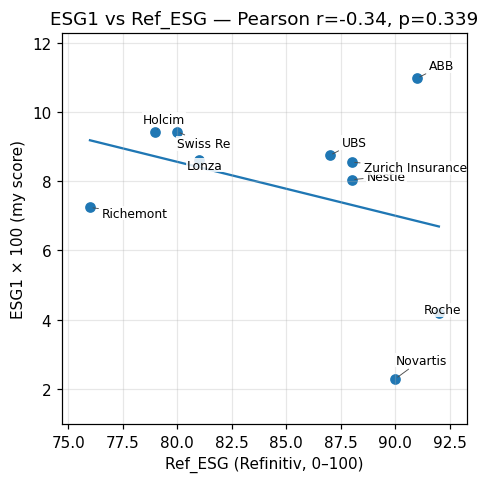

--- ESG1 vs Ref_ESGC ---


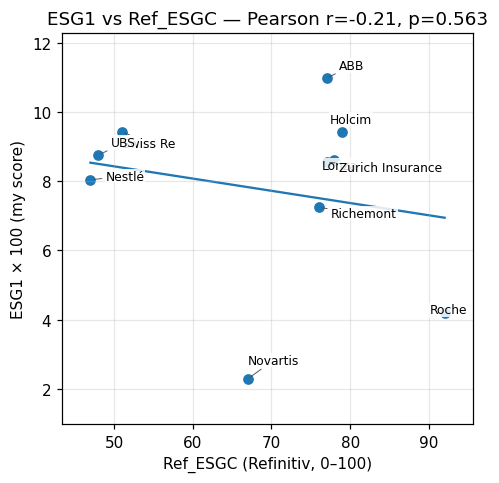


--- ESG2 vs Ref_ESG ---


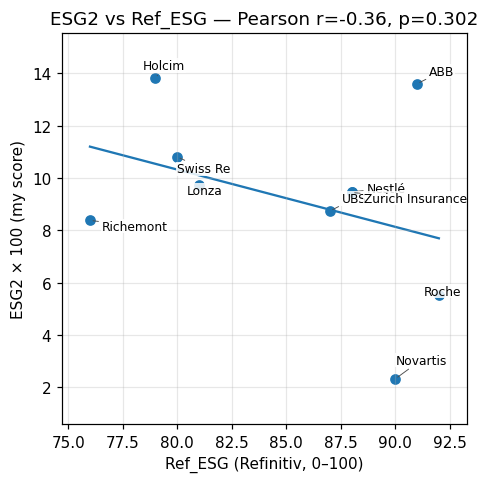

--- ESG2 vs Ref_ESGC ---


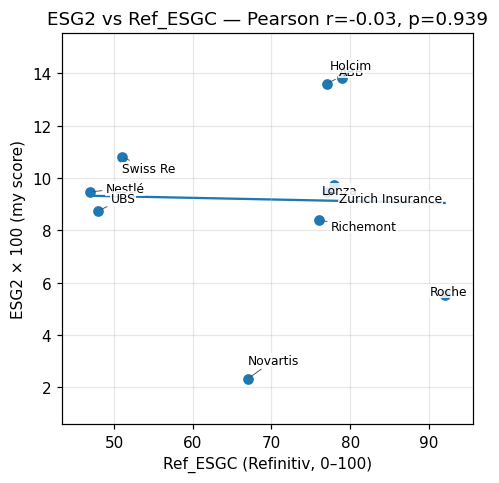


--- ESG3 vs Ref_ESG ---


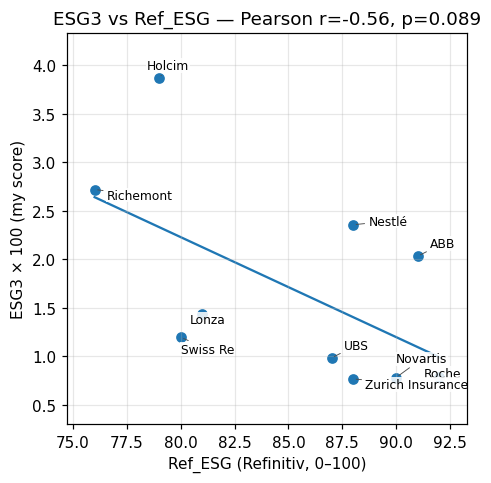

--- ESG3 vs Ref_ESGC ---


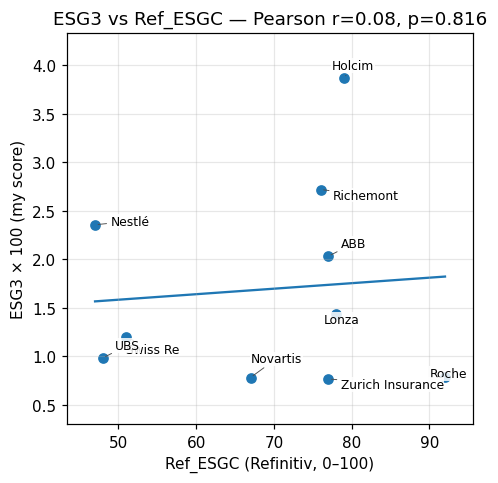


--- ESG4 vs Ref_ESG ---


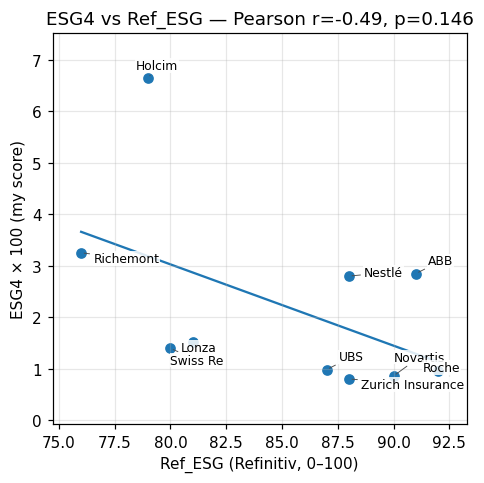

--- ESG4 vs Ref_ESGC ---


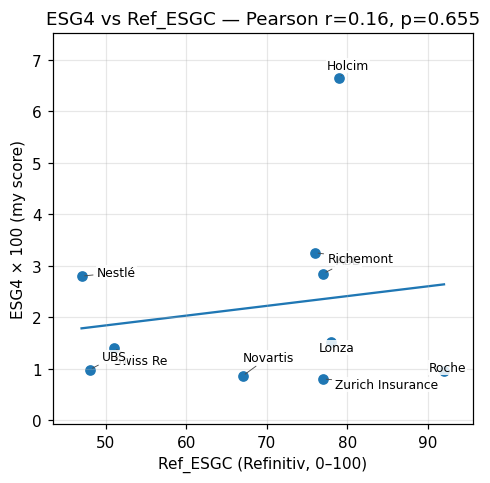


--- ESG5 vs Ref_ESG ---


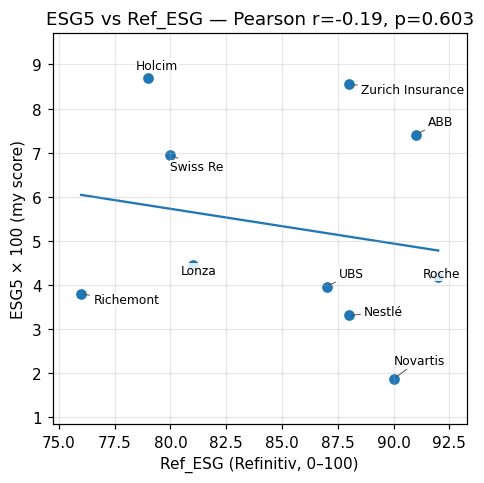

--- ESG5 vs Ref_ESGC ---


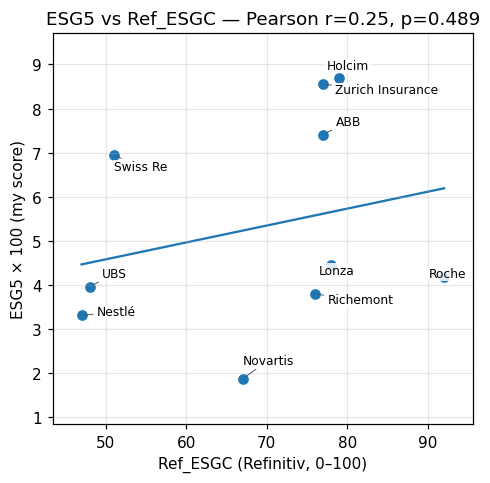


--- ESG6 vs Ref_ESG ---


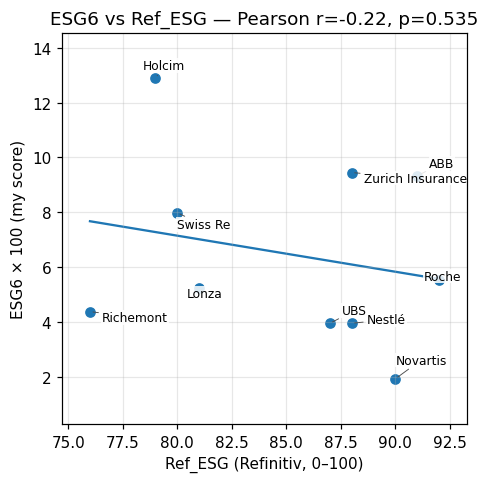

--- ESG6 vs Ref_ESGC ---


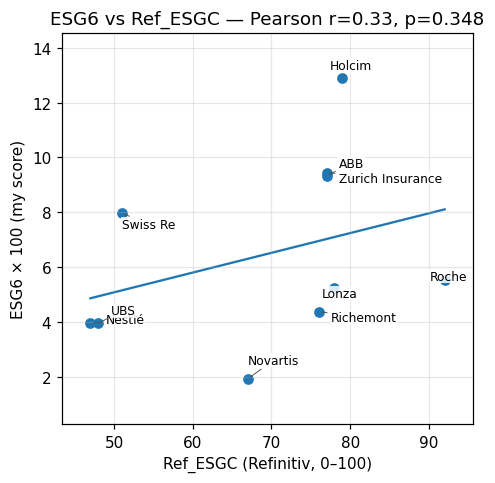


--- ESG7 vs Ref_ESG ---


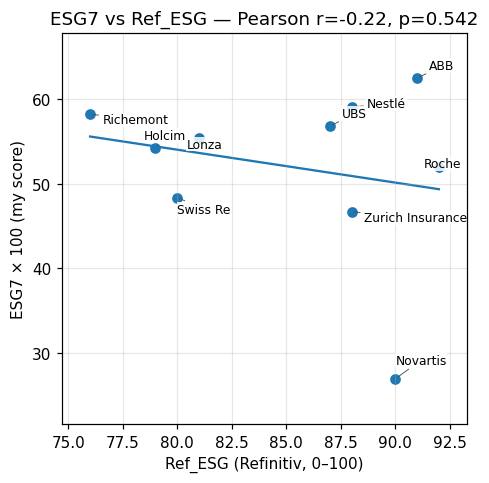

--- ESG7 vs Ref_ESGC ---


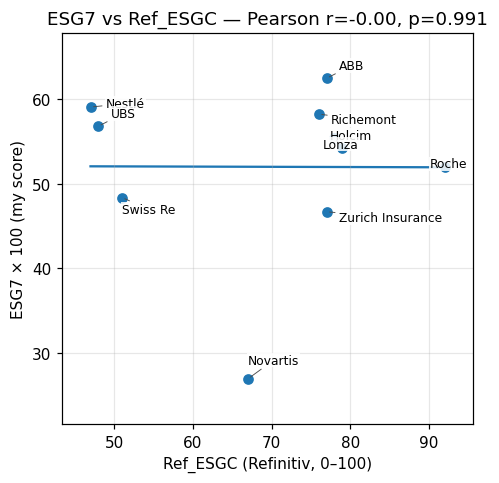


--- ESG8 vs Ref_ESG ---


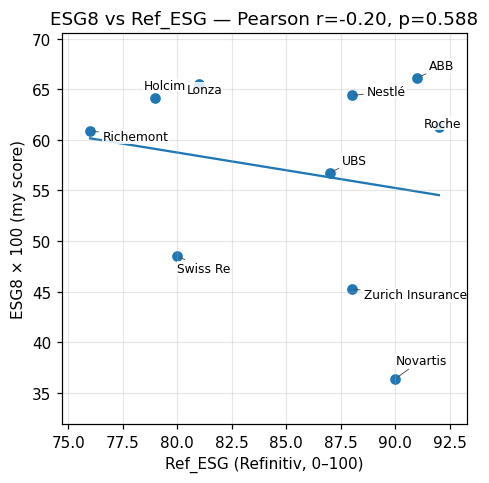

--- ESG8 vs Ref_ESGC ---


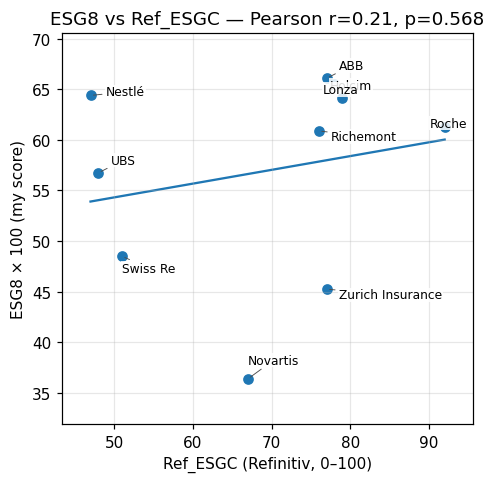


--- ESG9 vs Ref_ESG ---


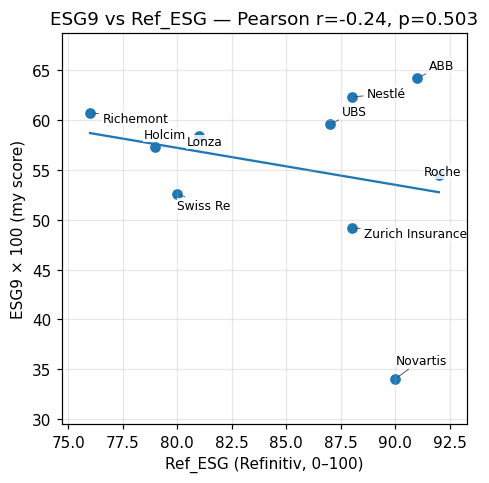

--- ESG9 vs Ref_ESGC ---


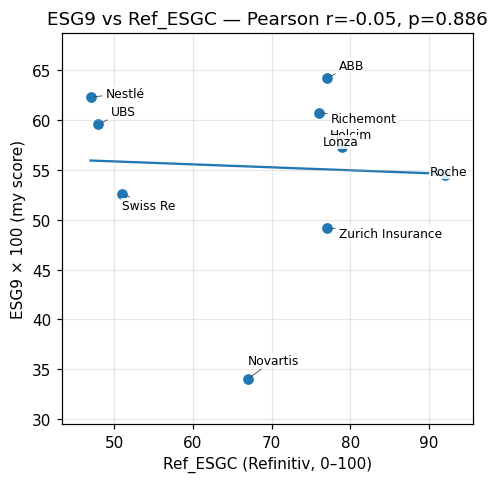


--- ESG10 vs Ref_ESG ---


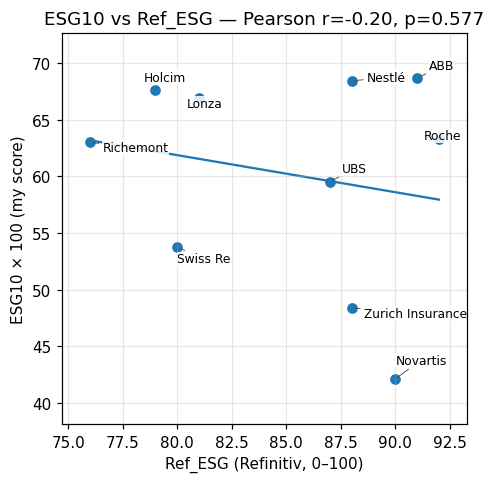

--- ESG10 vs Ref_ESGC ---


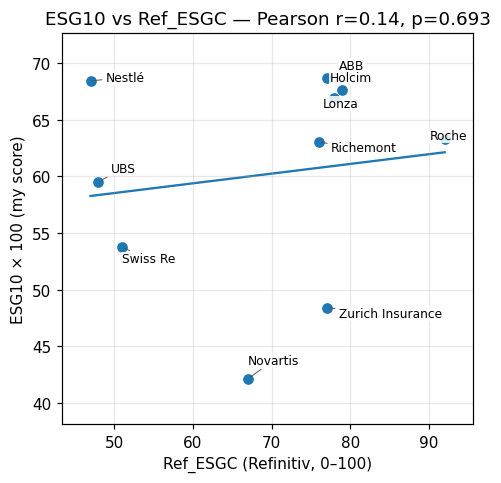

In [15]:
# 7.4 Visuals — fixed labeling

# !pip install adjustText  # (optionnel) pour un placement optimal

import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def short_name(name: str) -> str:
    if not isinstance(name, str):
        return str(name)
    drop = {"ag","sa","ltd","group","holding","company","compagnie","financière"}
    words = [w for w in re.split(r"\s+", name) if w.strip()]
    keep = [w for w in words if w.lower() not in drop]
    s = " ".join(keep) if keep else name
    return s if len(s) <= 18 else s[:18] + "…"

def plot_esg_vs_ref_clean(esg_variant="ESG1", ref_col="Ref_ESG"):
    assert esg_variant in ESG_cols and ref_col in {"Ref_ESG","Ref_ESGC"}

    m = df_ref[esg_variant].notna() & df_ref[ref_col].notna()
    xs = df_ref.loc[m, ref_col].to_numpy()
    ys = (df_ref.loc[m, esg_variant].to_numpy()) * 100
    labs = df_ref.loc[m, "Company"].map(short_name).to_numpy()

    if len(xs) < 3:
        print("Not enough points to plot.")
        return

    r, p = pearsonr(xs, ys)

    fig, ax = plt.subplots(figsize=(4.5, 4.5), dpi=110)
    ax.scatter(xs, ys, zorder=1)

    # regression line
    a, b = np.polyfit(xs, ys, 1)
    xv = np.linspace(xs.min(), xs.max(), 100)
    ax.plot(xv, a * xv + b, zorder=0)

    # labels — try adjustText first
    try:
        from adjustText import adjust_text
        texts = [ax.text(x, y, lab, fontsize=8,
                         bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=0.5))
                 for x, y, lab in zip(xs, ys, labs)]
        adjust_text(
            texts, ax=ax,
            expand_points=(1.2, 1.8),
            expand_text=(1.05, 1.2),
            force_points=0.25, force_text=0.25, lim=300,
            arrowprops=dict(arrowstyle='-', lw=0.6, color='0.3')
        )
    except Exception:
        # fallback: pixel-based offsets (no drift with axis scale) + small arrow to the point
        offsets = [(8,6),(8,-6),(-8,6),(-8,-6),(10,0),(0,10),(-10,0),(0,-10)]
        for i, (x, y, lab) in enumerate(zip(xs, ys, labs)):
            dx, dy = offsets[i % len(offsets)]
            ax.annotate(
                lab, xy=(x, y), xytext=(dx, dy), textcoords="offset points",
                fontsize=8, zorder=2,
                bbox=dict(facecolor="white", alpha=0.85, edgecolor="none", pad=0.5),
                arrowprops=dict(arrowstyle='-', lw=0.6, color='0.3')
            )

    # comfy margins
    x_pad = (xs.max() - xs.min()) * 0.08 if xs.max() > xs.min() else 1.0
    y_pad = (ys.max() - ys.min()) * 0.15 if ys.max() > ys.min() else 1.0
    ax.set_xlim(xs.min() - x_pad, xs.max() + x_pad)
    ax.set_ylim(ys.min() - y_pad, ys.max() + y_pad)

    ax.grid(True, alpha=0.3)
    ax.set_xlabel(f"{ref_col} (Refinitiv, 0–100)")
    ax.set_ylabel(f"{esg_variant} × 100 (my score)")
    ax.set_title(f"{esg_variant} vs {ref_col} — Pearson r={r:.2f}, p={p:.3f}")
    plt.tight_layout()
    plt.show()

# Replot all variants against both Refinitiv metrics
for v in ESG_cols:
    print(f"\n--- {v} vs Ref_ESG ---")
    plot_esg_vs_ref_clean(v, "Ref_ESG")
    print(f"--- {v} vs Ref_ESGC ---")
    plot_esg_vs_ref_clean(v, "Ref_ESGC")


### 5. Comparison: Custom ESG Scores vs. Refinitiv Controversy Scores

In [16]:
# 9. Compare my 10 ESG variants to Refinitiv **Controversies** (year = `year`)
# ---------------------------------------------------------------------------
# Goal: do my scores line up with the Refinitiv "ESG Controversies Score"?
# - Ref_C (0–100): higher = fewer controversies (better).

# I need: ESG_year (Company × ESG1..ESG10), refinitiv_path, year
if "ESG_year" not in globals():
    raise RuntimeError("I need `ESG_year` from the ESG loading step (section 6).")
if "refinitiv_path" not in globals():
    raise RuntimeError("I need `refinitiv_path` pointing to 'SMI companies.xlsx'.")
if "year" not in globals():
    year = 2022

import numpy as np
import pandas as pd
from IPython.display import display
from scipy.stats import spearmanr, kendalltau, pearsonr

# Small helpers (standalone)
def parse_comma_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.number)): return float(x)
    s = str(x).strip().replace(" ", "")
    s = s.replace(".", "").replace(",", ".")
    try: return float(s)
    except: return np.nan

def rank_desc(s):  # higher is better -> rank 1 = highest
    return s.rank(ascending=False, method="min")

def mean_abs_rank_error(r1, r2):
    m = r1.notna() & r2.notna()
    if m.sum() == 0: return np.nan
    return (r1[m] - r2[m]).abs().mean()

def jaccard_topk(a, b):
    u = a | b
    return len(a & b) / len(u) if len(u) else np.nan

# 9.1 Load Refinitiv Controversies for my year
ref_c = pd.read_excel(refinitiv_path, sheet_name="Refinitiv ESG").rename(columns={
    "company": "Company",
    "year": "year",
    "ESG Controversies Score": "Ref_C",
})
ref_c["Company"] = ref_c["Company"].astype(str).str.strip()
ref_c["year"] = ref_c["year"].astype(int)
ref_c["Ref_C"] = ref_c["Ref_C"].apply(parse_comma_float)

ref_cy = ref_c.loc[ref_c["year"] == year, ["Company", "Ref_C"]].copy()

print(f"Refinitiv Controversies ({year}) – shape:", ref_cy.shape)
display(ref_cy.head())

# 9.2 Merge with my ESG variants (same companies, same year)
df_cont = ESG_year.merge(ref_cy, on="Company", how="inner").copy()
ESG_cols = [c for c in df_cont.columns if c.startswith("ESG") and c[3:].isdigit()]

# build ranks (1 = better)
for v in ESG_cols:
    df_cont[f"{v}_rank"] = rank_desc(df_cont[v])
df_cont["Ref_C_rank"] = rank_desc(df_cont["Ref_C"])  # higher Ref_C (fewer controversies) = better

print("Merged (my ESG vs Refinitiv Controversies) – companies in common:", df_cont["Company"].nunique())
display(df_cont.head())

# 9.3 Summary table — single panel vs Ref_C
def summarize_vs_controversies(k=3, show=True):
    """
    For each ESG variant (ESG1..ESG10), compare to Ref_C (higher = fewer controversies).
    Report: Pearson on values, Spearman/Kendall on ranks, MAR (rank gap), Jaccard@k (top-k overlap).
    """
    rows = []
    for v in ESG_cols:
        m = df_cont[v].notna() & df_cont["Ref_C"].notna()
        n = int(m.sum())
        if n >= 3:
            # values
            r_lin, p_lin = pearsonr(df_cont.loc[m, v], df_cont.loc[m, "Ref_C"])
            # ranks
            rho, p_rho = spearmanr(df_cont.loc[m, f"{v}_rank"], df_cont.loc[m, "Ref_C_rank"])
            tau, p_tau = kendalltau(df_cont.loc[m, f"{v}_rank"], df_cont.loc[m, "Ref_C_rank"])
            mar = mean_abs_rank_error(df_cont[f"{v}_rank"], df_cont["Ref_C_rank"])
            # top-k overlap (top ESG vs top Ref_C)
            sub = df_cont.loc[m, ["Company", v, "Ref_C"]].copy()
            top_esg = set(sub.sort_values(by=v, ascending=False)["Company"].head(k))
            top_refc = set(sub.sort_values(by="Ref_C", ascending=False)["Company"].head(k))
            jac = jaccard_topk(top_esg, top_refc)
        else:
            r_lin=p_lin=rho=p_rho=tau=p_tau=mar=jac=np.nan

        rows.append({
            "ESG_variant": v, "n": n,
            "pearson": r_lin, "pearson_p": p_lin,
            "spearman": rho, "spearman_p": p_rho,
            "kendall": tau, "kendall_p": p_tau,
            "MAR_ranks": mar, "Jaccard@k": jac
        })

    out = (pd.DataFrame(rows)
             .sort_values(["spearman","kendall","MAR_ranks"], ascending=[False, False, True])
             .reset_index(drop=True)
             .round({"pearson":3,"spearman":3,"kendall":3,"MAR_ranks":2,"Jaccard@k":3}))

    if show:
        print("\nMy ESG vs Refinitiv Controversies Score (Ref_C, higher = fewer controversies):")
        display(out[["ESG_variant","n","spearman","spearman_p","kendall","kendall_p",
                     "MAR_ranks","Jaccard@k","pearson","pearson_p"]])
        print("""
Reading:
- If my ESG is a “goodness” score, I expect POSITIVE links (higher ESG ↔ higher Ref_C).
- MAR lower = closer ranks. Jaccard@k = overlap of top-k “best ESG” with top-k “fewest controversies”.
""")

    return out

# Run it
tbl_refc = summarize_vs_controversies(k=3, show=True)


Refinitiv Controversies (2022) – shape: (10, 2)


,Company,Ref_C
1,ABB Ltd,64.0
4,Compagnie Financière Richemont,100.0
7,Holcim Ltd,100.0
10,Lonza Group AG,100.0
13,Nestlé SA,6.0


Merged (my ESG vs Refinitiv Controversies) – companies in common: 10


,Company,ESG1,ESG2,ESG3,ESG4,ESG5,ESG6,ESG7,ESG8,ESG9,...,ESG2_rank,ESG3_rank,ESG4_rank,ESG5_rank,ESG6_rank,ESG7_rank,ESG8_rank,ESG9_rank,ESG10_rank,Ref_C_rank
0,ABB Ltd,0.109693,0.136015,0.020308,0.028472,0.074099,0.093254,0.624445,0.660796,0.642113,...,2.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,6.0
1,Compagnie Financière Richemont,0.072407,0.083839,0.027183,0.032516,0.037893,0.043817,0.582110,0.608868,0.607595,...,8.0,2.0,2.0,8.0,7.0,3.0,6.0,3.0,6.0,1.0
2,Holcim Ltd,0.094225,0.138134,0.038647,0.066408,0.086867,0.128841,0.541680,0.641559,0.573041,...,1.0,1.0,1.0,1.0,1.0,6.0,4.0,6.0,3.0,1.0
3,Lonza Group AG,0.086245,0.097356,0.014345,0.015204,0.044540,0.052567,0.553411,0.655471,0.583997,...,4.0,5.0,5.0,5.0,6.0,5.0,2.0,5.0,4.0,1.0
4,Nestlé SA,0.080415,0.094744,0.023548,0.027973,0.033052,0.039559,0.590447,0.643832,0.623198,...,5.0,3.0,4.0,9.0,8.0,2.0,3.0,2.0,2.0,10.0



My ESG vs Refinitiv Controversies Score (Ref_C, higher = fewer controversies):


,ESG_variant,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson,pearson_p
0,ESG6,10,0.450,0.191665,0.310,0.228092,3.0,0.2,0.342,0.334129
1,ESG5,10,0.381,0.276776,0.310,0.228092,3.2,0.2,0.235,0.512477
2,ESG4,10,0.244,0.497146,0.167,0.516337,3.2,0.5,0.343,0.331941
3,ESG8,10,0.225,0.531776,0.119,0.642954,3.4,0.0,0.329,0.352768
4,ESG3,10,0.194,0.591542,0.119,0.642954,3.2,0.5,0.304,0.392916
5,ESG10,10,0.131,0.717652,0.072,0.780902,3.6,0.2,0.270,0.450162
6,ESG2,10,0.019,0.958979,0.024,0.926130,3.8,0.2,0.087,0.811411
7,ESG7,10,-0.113,0.756882,-0.072,0.780902,4.2,0.2,0.108,0.767188
8,ESG9,10,-0.113,0.756882,-0.072,0.780902,4.2,0.2,0.073,0.841987
9,ESG1,10,-0.150,0.679009,-0.072,0.780902,4.4,0.2,-0.095,0.794980



Reading:
- If my ESG is a “goodness” score, I expect POSITIVE links (higher ESG ↔ higher Ref_C).
- MAR lower = closer ranks. Jaccard@k = overlap of top-k “best ESG” with top-k “fewest controversies”.



### 6. Comparison: Refinitiv ESG Scores vs. Carbon Intensity

We now test whether Refinitiv’s ESG scores show a stronger correlation with companies’ carbon intensity.

Refinitiv (2022) – shape: (10, 3)


,Company,Ref_E,Ref_ESG
1,ABB Ltd,97.0,91.0
4,Compagnie Financière Richemont,67.0,76.0
7,Holcim Ltd,74.0,79.0
10,Lonza Group AG,53.0,81.0
13,Nestlé SA,87.0,88.0


Merged (Refinitiv + Carbon) – companies in common: 10


,Company,Carbon_Total,Carbon_wo_Scope3,Carbon_Total_log,Carbon_wo_Scope3_log,Ref_E,Ref_ESG,Ref_E_rank,Ref_ESG_rank,Carbon_Total_rank,Carbon_wo_Scope3_rank
0,ABB Ltd,13299.746,7.490,9.495575,2.138889,97.0,91.0,1.0,2.0,10.0,6.0
1,Compagnie Financière Richemont,82.606,3.719,4.426115,1.551597,67.0,76.0,8.0,10.0,3.0,3.0
2,Holcim Ltd,4215.455,2646.914,8.346750,7.881527,74.0,79.0,6.0,9.0,9.0,10.0
3,Lonza Group AG,366.637,83.536,5.907096,4.437177,53.0,81.0,10.0,7.0,7.0,9.0
4,Nestlé SA,1158.483,59.112,7.055729,4.096209,87.0,88.0,4.0,4.0,8.0,8.0


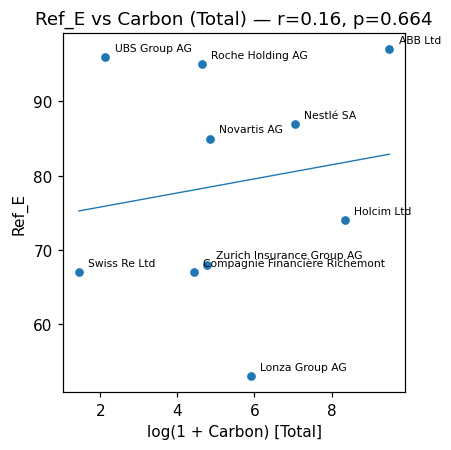

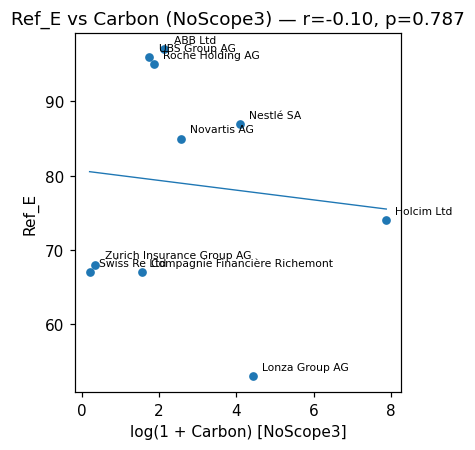

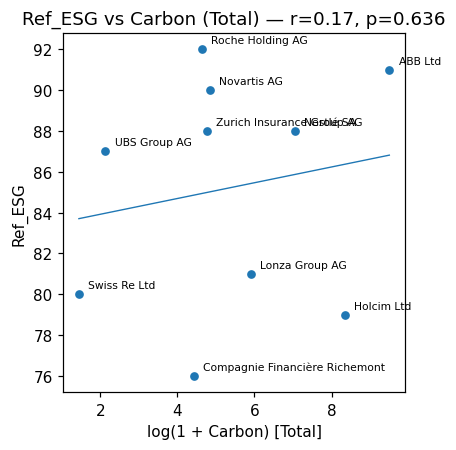

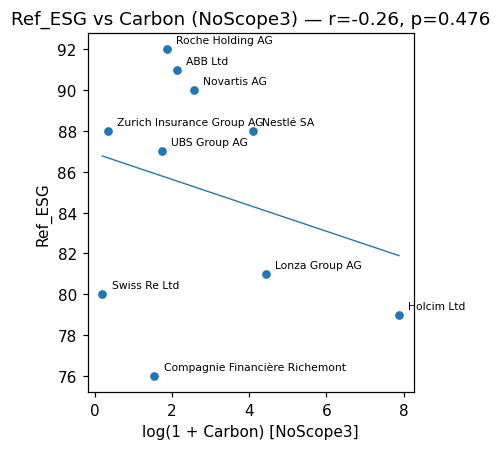


Refinitiv vs carbon (Total) — best by rank agreement (higher Spearman/Kendall, lower MAR):


,metric,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
0,Ref_E,10,-0.261,0.465685,-0.18,0.472498,3.5,0.2,0.157,0.664469
1,Ref_ESG,10,-0.267,0.454986,-0.18,0.472498,3.7,0.0,0.171,0.635817



Refinitiv vs carbon (Total) — best by Pearson on values (more NEGATIVE is better):


,metric,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
0,Ref_E,10,0.157,0.664469,-0.261,-0.18,3.5,0.2
1,Ref_ESG,10,0.171,0.635817,-0.267,-0.18,3.7,0.0



Refinitiv vs carbon (NoScope3) — best by rank agreement (higher Spearman/Kendall, lower MAR):


,metric,n,spearman,spearman_p,kendall,kendall_p,MAR_ranks,Jaccard@k,pearson_logX,pearson_p
1,Ref_ESG,10,-0.055,0.880676,0.045,0.857462,3.7,0.0,-0.256,0.475771
0,Ref_E,10,-0.103,0.776334,-0.045,0.857462,3.7,0.0,-0.098,0.786762



Refinitiv vs carbon (NoScope3) — best by Pearson on values (more NEGATIVE is better):


,metric,n,pearson_logX,pearson_p,spearman,kendall,MAR_ranks,Jaccard@k
1,Ref_ESG,10,-0.256,0.475771,-0.055,0.045,3.7,0.0
0,Ref_E,10,-0.098,0.786762,-0.103,-0.045,3.7,0.0



How I read these:
- Pearson r (values): negative → higher Refinitiv score when carbon is lower (good if I expect 'score↑ ⇒ carbon↓').
- Spearman/Kendall (ranks): do the ORDERINGS match 'lowest carbon first'? (higher is better).
- MAR: average rank gap (lower is better).
- Jaccard@k: overlap of top-k by Refinitiv and top-k lowest-carbon (0..1).



In [17]:
# 8. Refinitiv vs carbon (same logic as my scores, year = `year`)

# I reuse helpers from above: parse_comma_float, rank_desc, rank_asc,
# mean_abs_rank_error, jaccard_topk. I also reuse `carb_year` (carbon 2022).

# 8.1 Load Refinitiv (E pillar + overall ESG without controversies) for my year
ref_raw = pd.read_excel(refinitiv_path, sheet_name="Refinitiv ESG").rename(columns={
    "company": "Company",
    "year": "year",
    "Environmental Score": "Ref_E",
    "ESG Score": "Ref_ESG"    # overall without controversies
})
ref_raw["Company"] = ref_raw["Company"].astype(str).str.strip()
ref_raw["year"] = ref_raw["year"].astype(int)
for c in ["Ref_E", "Ref_ESG"]:
    ref_raw[c] = ref_raw[c].apply(parse_comma_float)

ref22 = ref_raw.loc[ref_raw["year"] == year, ["Company", "Ref_E", "Ref_ESG"]].copy()
print(f"Refinitiv ({year}) – shape:", ref22.shape)
display(ref22.head())

# 8.2 Merge with carbon (same companies, same year) and build ranks
rdf = carb_year.merge(ref22, on="Company", how="inner").copy()
rdf["Ref_E_rank"]   = rank_desc(rdf["Ref_E"])     # higher E = better
rdf["Ref_ESG_rank"] = rank_desc(rdf["Ref_ESG"])   # higher ESG = better
rdf["Carbon_Total_rank"]     = rank_asc(rdf["Carbon_Total"])       # lower carbon = better
rdf["Carbon_wo_Scope3_rank"] = rank_asc(rdf["Carbon_wo_Scope3"])   # lower carbon = better

print("Merged (Refinitiv + Carbon) – companies in common:", rdf["Company"].nunique())
display(rdf.head())

# 8.3 Visuals — simple scatter with fit line (log carbon on X, Refinitiv score on Y) + Pearson
def scatter_ref_vs_carbon(ref_metric="Ref_E", carbon_metric="Total"):
    """
    I plot: X = log(1 + carbon), Y = Refinitiv metric (Ref_E or Ref_ESG).
    I add a fit line and I print Pearson (values).
    Reading: NEGATIVE Pearson → higher score when carbon is lower (that's what I'd expect).
    """
    assert ref_metric in {"Ref_E", "Ref_ESG"}
    xcol = "Carbon_Total_log" if carbon_metric == "Total" else "Carbon_wo_Scope3_log"

    m = rdf[xcol].notna() & rdf[ref_metric].notna()
    xs = rdf.loc[m, xcol].to_numpy()
    ys = rdf.loc[m, ref_metric].to_numpy()
    labs = rdf.loc[m, "Company"].to_numpy()

    if len(xs) < 3:
        print("Not enough points.")
        return

    r, p = pearsonr(xs, ys)

    plt.figure(figsize=(4.2, 4.2), dpi=110)
    plt.scatter(xs, ys, s=22)
    # fit line
    a, b = np.polyfit(xs, ys, 1)
    xv = np.linspace(xs.min(), xs.max(), 100)
    plt.plot(xv, a * xv + b, lw=0.9)

    # tiny labels (just a small offset so I see who is who)
    for xi, yi, lab in zip(xs, ys, labs):
        plt.annotate(lab, (xi, yi), textcoords="offset points", xytext=(6, 4), fontsize=7)

    plt.xlabel(f"log(1 + Carbon) [{carbon_metric}]")
    plt.ylabel(ref_metric)
    plt.title(f"{ref_metric} vs Carbon ({carbon_metric}) — r={r:.2f}, p={p:.3f}")
    plt.tight_layout(); plt.show()

# Example quick looks (comment/uncomment as you want)
scatter_ref_vs_carbon("Ref_E",   "Total")
scatter_ref_vs_carbon("Ref_E",   "NoScope3")
scatter_ref_vs_carbon("Ref_ESG", "Total")
scatter_ref_vs_carbon("Ref_ESG", "NoScope3")

# 8.4 Tables — rank agreement + MAR + Jaccard, plus Pearson on values
def summarize_ref_vs_carbon(carbon="Total", k=3):
    """
    I compare Refinitiv ranks to 'lowest carbon first' ranks.
    I show for both metrics (Ref_E, Ref_ESG):
      - Spearman / Kendall on ranks (higher = closer ordering to low carbon)
      - MAR (mean absolute rank gap) (lower = closer)
      - Pearson r on values (log carbon vs score) (more NEGATIVE = better low-carbon alignment)
      - Jaccard@k (overlap between top-k by Refinitiv and top-k lowest carbon)
    """
    assert carbon in {"Total", "NoScope3"}
    c_rank = "Carbon_Total_rank" if carbon == "Total" else "Carbon_wo_Scope3_rank"
    c_val  = "Carbon_Total"      if carbon == "Total" else "Carbon_wo_Scope3"
    c_log  = "Carbon_Total_log"  if carbon == "Total" else "Carbon_wo_Scope3_log"

    rows = []
    for metric in ["Ref_E", "Ref_ESG"]:
        r_rank = f"{metric}_rank"
        m = rdf[metric].notna() & rdf[c_val].notna() & rdf[c_log].notna()
        n = int(m.sum())
        if n < 3:
            rows.append({"metric": metric, "n": n,
                         "spearman": np.nan, "spearman_p": np.nan,
                         "kendall": np.nan, "kendall_p": np.nan,
                         "MAR_ranks": np.nan,
                         "pearson_logX": np.nan, "pearson_p": np.nan,
                         "Jaccard@k": np.nan})
            continue

        # ranks
        rho, p_rho = spearmanr(rdf.loc[m, r_rank], rdf.loc[m, c_rank])
        tau, p_tau = kendalltau(rdf.loc[m, r_rank], rdf.loc[m, c_rank])
        mar = mean_abs_rank_error(rdf[r_rank], rdf[c_rank])

        # values (Pearson on log carbon vs score)
        r_lin, p_lin = pearsonr(rdf.loc[m, c_log], rdf.loc[m, metric])

        # top-k overlap
        sub = rdf.loc[m, ["Company", metric, c_val]].copy()
        top_ref  = set(sub.sort_values(by=metric, ascending=False)["Company"].head(k))
        top_lowC = set(sub.sort_values(by=c_val,   ascending=True )["Company"].head(k))
        jac = jaccard_topk(top_ref, top_lowC)

        rows.append({
            "metric": metric, "n": n,
            "spearman": rho, "spearman_p": p_rho,
            "kendall": tau, "kendall_p": p_tau,
            "MAR_ranks": mar,
            "pearson_logX": r_lin, "pearson_p": p_lin,
            "Jaccard@k": jac
        })

    out = pd.DataFrame(rows).round({"spearman":3, "kendall":3, "MAR_ranks":2,
                                    "pearson_logX":3, "Jaccard@k":3})

    print(f"\nRefinitiv vs carbon ({carbon}) — best by rank agreement (higher Spearman/Kendall, lower MAR):")
    display(out.sort_values(["spearman","kendall","MAR_ranks"], ascending=[False, False, True])
              [["metric","n","spearman","spearman_p","kendall","kendall_p","MAR_ranks","Jaccard@k","pearson_logX","pearson_p"]])

    print(f"\nRefinitiv vs carbon ({carbon}) — best by Pearson on values (more NEGATIVE is better):")
    display(out.sort_values(["pearson_logX","MAR_ranks"], ascending=[True, True])
              [["metric","n","pearson_logX","pearson_p","spearman","kendall","MAR_ranks","Jaccard@k"]])

    return out

ref_tbl_total   = summarize_ref_vs_carbon("Total",   k=3)   # Scope 1–3
ref_tbl_noscope = summarize_ref_vs_carbon("NoScope3", k=3)  # Scope 1–2

print("""
How I read these:
- Pearson r (values): negative → higher Refinitiv score when carbon is lower (good if I expect 'score↑ ⇒ carbon↓').
- Spearman/Kendall (ranks): do the ORDERINGS match 'lowest carbon first'? (higher is better).
- MAR: average rank gap (lower is better).
- Jaccard@k: overlap of top-k by Refinitiv and top-k lowest-carbon (0..1).
""")
